In [1]:

# # xAG予測コンペ　ベースラインコード（その2）
# 
# ベースラインコード（host_baseline_001.ipynb）について、特徴量の追加作成やパラメータ最適化を行った改善版コードです。

In [2]:


#第一回はこちら
#https://www.kaggle.com/competitions/dsdojo_1/overview


# ---
# ## セットアップ
# 
# 

In [3]:


# 必要モジュールでColab環境にないものはinstall
get_ipython().system('pip install japanize_matplotlib')
get_ipython().system('pip install catboost')


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:


# 必要モジュールをimport
import json
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import japanize_matplotlib
import networkx as nx
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ランダム性を伴う処理を行うため、結果の再現性を保つにはシード値を固定しておく必要があります
SEED = 42
np.random.seed(SEED)

In [5]:


# コンペの評価指標に合わせた目的関数/評価関数の定義
WEIGHTED_TARGET_THRESHOLD = 0.28
WEIGHTED_POSITIVE_WEIGHT = 5.0

def make_sample_weight(y_true):
    """
    ターゲットに応じた重みベクトルを生成
    """
    y_array = np.asarray(y_true, dtype=float)
    return np.where(y_array >= WEIGHTED_TARGET_THRESHOLD, WEIGHTED_POSITIVE_WEIGHT, 1.0)

def weighted_rmse(y_true, y_pred):
    """
    重み付きRMSE評価関数
    コンペの評価指標に合わせて実装
    """
    weights = make_sample_weight(y_true)
    squared_errors = (y_true - y_pred) ** 2
    weighted_squared_errors = weights * squared_errors
    pw_rmse = np.sqrt(np.mean(weighted_squared_errors) + 1e-9)
    return float(pw_rmse)

def weighted_rmse_feval(y_pred, dtrain):
    """
    LightGBM用の重み付きRMSE評価関数
    """
    y_true = dtrain.get_label()
    weighted_rmse_value = weighted_rmse(y_true, y_pred)
    return "weighted_rmse", weighted_rmse_value, False

In [6]:


# 表示できるdfの行、列数を増やす
pd.set_option("display.max_rows", 100)    # 最大100行まで表示
pd.set_option("display.max_columns", 100) # 最大100列まで表示


# ## データ読み込み

In [7]:


# ローカル実行用のパス設定
base_path = '../../data'
print(f"データ読み込み元パス: {base_path}")

# データ読み込み
# player_idやmatch_idの数値的大小に意味はないのでstring形式で読み込み
train_df = pd.read_csv(f"{base_path}/match_train_data.csv", dtype={"player_id": "string", "match_id": "string"})
test_df = pd.read_csv(f"{base_path}/match_test_data.csv", dtype={"player_id": "string", "match_id": "string"})
actions_df = pd.read_csv(f"{base_path}/action_data.csv", dtype={"player_id": "string", "match_id": "string"})
submission_df = pd.read_csv(f"{base_path}/sample_submission.csv")

print(f"trainデータ形状: {train_df.shape}")
display(train_df.head(3))

print(f"\ntestデータ形状: {test_df.shape}")
display(test_df.head(3))

print(f"\nアクションデータ形状: {actions_df.shape}")
display(actions_df.head(3))


# ## 特徴量エンジニアリング - 基本特徴量
# 
# まず、001と同じ基本的な特徴量を作成します。

データ読み込み元パス: ../../data
trainデータ形状: (27870, 14)


,Date,Day,Comp,Round,Venue,Result,Squad,Opponent,xAG,player_name,birth_date,URL,player_id,match_id
0,2017-09-09,Sat,Premier League,Matchweek 4,Away,W 2–1,Chelsea,Leicester City,0.1,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499753
1,2017-09-17,Sun,Premier League,Matchweek 5,Home,D 0–0,Chelsea,Arsenal,0.0,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499760
2,2017-09-23,Sat,Premier League,Matchweek 6,Away,W 4–0,Chelsea,Stoke City,0.0,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499776



testデータ形状: (12798, 13)


,Date,Day,Comp,Round,Venue,Result,Squad,Opponent,player_name,birth_date,URL,player_id,match_id
0,2018-02-12,Mon,Premier League,Matchweek 27,Home,W 3–0,Chelsea,West Brom,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499979
1,2018-02-25,Sun,Premier League,Matchweek 28,Away,L 1–2,Chelsea,Manchester Utd,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2499996
2,2018-03-04,Sun,Premier League,Matchweek 29,Away,L 0–1,Chelsea,Manchester City,Eden Hazard,1991-01-07,https://fbref.com/en/players/a39bb753/Eden-Hazard,25707,2500004



アクションデータ形状: (2303958, 26)


,match_id,match_date,match_venue,match_status,home_team_name,away_team_name,match_winner,period_id,time_seconds,team_id,is_home,player_id,start_x,start_y,end_x,end_y,type_name,result_name,bodypart_name,team_name_short,birth_date,player_name,jersey_number,minutes_played,is_starter,competition
0,2576335,"May 20, 2018 at 8:45:00 PM GMT+2",NaN,Played,SS Lazio,FC Internazionale Milano,3161,1,2.417590,3161,False,3344,53.55,34.00,65.10,39.44,pass,success,foot,Internazionale,1993-02-12,Rafael Alcântara do Nascimento,0,69,True,Italian first division
1,2576335,"May 20, 2018 at 8:45:00 PM GMT+2",NaN,Played,SS Lazio,FC Internazionale Milano,3161,1,3.904412,3161,False,116349,65.10,39.44,66.15,61.88,pass,success,foot,Internazionale,1991-08-24,Matías Vecino Falero,0,96,True,Italian first division
2,2576335,"May 20, 2018 at 8:45:00 PM GMT+2",NaN,Played,SS Lazio,FC Internazionale Milano,3161,1,6.484211,3161,False,135903,66.15,61.88,69.30,48.96,pass,success,foot,Internazionale,1994-05-27,João Pedro Cavaco Cancelo,0,96,True,Italian first division


In [8]:


# 所与のデータから簡単に計算できる年齢特徴量を追加する

# 2017/18シーズン終了時点での年齢を計算
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['birth_date'] = pd.to_datetime(train_df['birth_date'])
train_df['age'] = (train_df['Date'] - train_df['birth_date']).dt.days / 365.25

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['birth_date'] = pd.to_datetime(test_df['birth_date'])
test_df['age'] = (test_df['Date'] - test_df['birth_date']).dt.days / 365.25

print(f"\nマージ後のtrainデータ形状: {train_df.shape}")
print(f"\nマージ後のtestデータ形状: {test_df.shape}")


マージ後のtrainデータ形状: (27870, 15)

マージ後のtestデータ形状: (12798, 14)


In [9]:


# アクションデータから試合×選手レベルの特徴量を作成

# train/testに含まれる試合×選手の組み合わせを作成する
target_match_players_train = train_df[['match_id', 'player_id']].drop_duplicates()
target_match_players_test = test_df[['match_id', 'player_id']].drop_duplicates()
target_match_players = pd.concat([target_match_players_train, target_match_players_test]).drop_duplicates()

print(f"分析対象となる試合×選手: {len(target_match_players)}組")

# アクションデータのうち、train/testデータに含まれる試合×選手のアクションのみを抽出
relevant_actions = actions_df.merge(
    target_match_players,
    on=['match_id', 'player_id'],
    how='inner'
)
print(f"抽出されたアクション数: {len(relevant_actions)}件")

分析対象となる試合×選手: 40505組
抽出されたアクション数: 1867094件


In [10]:


# 位置データについては、homeとawayで基準が異なる
# homeの場合は、x=0が自陣ゴールライン、x=105が敵陣ゴールライン、y=0が右サイドライン、y=68が左サイドラインに対応する
# awayでは逆になるため、homeの選手とawayの選手で平均的なx,yの値を比較することができない
display(relevant_actions[(relevant_actions["type_name"] == "shot") & (relevant_actions["result_name"] == "success")][["is_home", "start_x", "start_y", "end_x", "end_y"]].head())

# そこで、位置を標準化するため、awayチームの場合は、x' = 105-x, y' = 68-yに修正する
relevant_actions.loc[relevant_actions['is_home'] == False, 'start_x'] = 105 - relevant_actions.loc[relevant_actions['is_home'] == False, 'start_x']
relevant_actions.loc[relevant_actions['is_home'] == False, 'end_x'] = 105 - relevant_actions.loc[relevant_actions['is_home'] == False, 'end_x']
relevant_actions.loc[relevant_actions['is_home'] == False, 'start_y'] = 68 - relevant_actions.loc[relevant_actions['is_home'] == False, 'start_y']
relevant_actions.loc[relevant_actions['is_home'] == False, 'end_y'] = 68 - relevant_actions.loc[relevant_actions['is_home'] == False, 'end_y']

relevant_actions[(relevant_actions["type_name"] == "shot") & (relevant_actions["result_name"] == "success")][["is_home", "start_x", "start_y", "end_x", "end_y"]].head()


# is_homeの値に関係なく、ゴールした場合end_x=105となっており、位置が標準化されている

,is_home,start_x,start_y,end_x,end_y
328,False,1.05,34.68,0.0,37.4
448,True,87.15,33.32,105.0,37.4
905,False,8.40,40.12,0.0,30.6
3296,True,100.80,29.92,105.0,30.6
4080,True,95.55,34.68,105.0,34.0


,is_home,start_x,start_y,end_x,end_y
328,False,103.95,33.32,105.0,30.6
448,True,87.15,33.32,105.0,37.4
905,False,96.60,27.88,105.0,37.4
3296,True,100.80,29.92,105.0,30.6
4080,True,95.55,34.68,105.0,34.0


In [11]:


# 基本的な統計特徴量の作成
# groupby()とagg()を組み合わせることで、列ごとに任意の集計方法を指定できる。
match_player_stats = (
    relevant_actions
    .groupby(['match_id', 'player_id'])
    .agg(
        action_count   = ('type_name', 'size'), # アクション数合計
        avg_x          = ('start_x', 'mean'), # 平均ポジション（前後方向）
        avg_y          = ('start_y', 'mean'), # 平均ポジション（左右方向）
        minutes_played = ('minutes_played', 'first')  # 出場時間
    )
    .round(2)
    .reset_index()
)

print(f"作成したデータ形状: {match_player_stats.shape}")
display(match_player_stats.head(3))

作成したデータ形状: (40041, 6)


,match_id,player_id,action_count,avg_x,avg_y,minutes_played
0,2499719,120339,80,53.84,30.40,70
1,2499719,12829,16,77.44,43.05,98
2,2499719,14763,30,67.24,35.36,75


In [12]:


# ゴール数の集計
# type_nameにshotが含まれて、成功したアクションはゴールになる
is_shot  = relevant_actions['type_name'].isin(['shot', 'shot_freekick', 'shot_penalty'])
is_success = relevant_actions['result_name'].eq('success')
is_goal = (is_shot & is_success).astype(int)

match_player_goals = (
    relevant_actions
    .assign(is_goal=is_goal) # is_goal列を追加
    .groupby(['match_id', 'player_id'], as_index=False)['is_goal']
    .sum() # ゴールであるアクションを合計
    .rename(columns={'is_goal': 'goal_count'})
)

print(f"作成したデータ形状: {match_player_goals.shape}")
display(match_player_goals.head(3))

作成したデータ形状: (40041, 3)


,match_id,player_id,goal_count
0,2499719,120339,0
1,2499719,12829,2
2,2499719,14763,1


In [13]:


# アクションタイプ数の集計
# type_name列の値ごとに数を集計する
action_type_stats = (
    relevant_actions
    .groupby(['match_id', 'player_id', 'type_name'])
    .size()
    .unstack(fill_value=0)  # type_name を列に展開、欠損は0で埋める
    .rename_axis(None, axis=1)
    .add_prefix('type_').add_suffix('_count') # 列名に接頭辞と接尾辞を追加する（type_nameがshotなら「type_shot_count」になる）
    .reset_index()
)

print(f"作成したデータ形状: {action_type_stats.shape}")
display(action_type_stats.head(3))

作成したデータ形状: (40041, 21)


,match_id,player_id,type_bad_touch_count,type_clearance_count,type_corner_crossed_count,type_corner_short_count,type_cross_count,type_dribble_count,type_foul_count,type_freekick_crossed_count,type_freekick_short_count,type_goalkick_count,type_interception_count,type_keeper_save_count,type_pass_count,type_shot_count,type_shot_freekick_count,type_shot_penalty_count,type_tackle_count,type_take_on_count,type_throw_in_count
0,2499719,120339,0,2,0,0,2,4,0,0,0,0,5,0,66,1,0,0,0,0,0
1,2499719,12829,0,0,0,0,1,2,0,0,0,0,0,0,11,2,0,0,0,0,0
2,2499719,14763,0,0,0,0,1,5,3,0,0,0,0,0,17,2,0,0,1,1,0


In [14]:


# ベース特徴量をtrain/testへマージ
train_df = (
    train_df
    .merge(match_player_stats, on=['match_id', 'player_id'], how='left')
    .merge(match_player_goals, on=['match_id', 'player_id'], how='left')
    .merge(action_type_stats, on=['match_id', 'player_id'], how='left')
)


test_df = (
    test_df
    .merge(match_player_stats, on=['match_id', 'player_id'], how='left')
    .merge(match_player_goals, on=['match_id', 'player_id'], how='left')
    .merge(action_type_stats, on=['match_id', 'player_id'], how='left')
)


action_type_cols = [col for col in train_df.columns if col.startswith('type_')]
stats_count_cols = ['action_count', 'minutes_played', 'goal_count']

for col in action_type_cols + stats_count_cols:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(0)
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(0)

print(f"ベース特徴量マージ後のtrainデータshape: {train_df.shape}")
print(f"ベース特徴量マージ後のtestデータshape: {test_df.shape}")


# ## 特徴量エンジニアリング - 応用特徴量
# 
# ここから、より高度な特徴量を作成していきます。各特徴量の意図と計算方法を詳しく説明します。

ベース特徴量マージ後のtrainデータshape: (27870, 39)
ベース特徴量マージ後のtestデータshape: (12798, 38)


In [15]:


# アクション成功率特徴量
# アシストに繋がる可能性を評価するため、各種アクションの成功率を計算する

# 成功率を計算するアクションタイプ
action_types_with_result = ['pass', 'shot', 'take_on', 'cross', 'corner_crossed', 'freekick_crossed']  # take_onはドリブルでの仕掛け

success_rates_list = []
print("アクション成功率特徴量を計算中...")

for (match_id, player_id), group in tqdm(relevant_actions.groupby(['match_id', 'player_id']), desc="Calculating success rates"):
    row_data = {'match_id': match_id, 'player_id': player_id}

    for action_type in action_types_with_result:
        type_actions = group[group['type_name'] == action_type] # 対象アクションを抽出

        if len(type_actions) > 0:
            success_count = len(type_actions[type_actions['result_name'] == 'success'])
            total_count = len(type_actions)

            # 成功率を計算
            success_rate = success_count / total_count
            row_data[f'{action_type}_success_rate'] = success_rate
        else:
            # 該当アクションがない場合は0
            row_data[f'{action_type}_success_rate'] = 0

    success_rates_list.append(row_data)

success_rates = pd.DataFrame(success_rates_list)

print(f"作成したデータ形状: {success_rates.shape}")
display(success_rates.head(3))

アクション成功率特徴量を計算中...


Calculating success rates:   0%|          | 0/40041 [00:00<?, ?it/s]

作成したデータ形状: (40041, 8)


,match_id,player_id,pass_success_rate,shot_success_rate,take_on_success_rate,cross_success_rate,corner_crossed_success_rate,freekick_crossed_success_rate
0,2499719,120339,0.924242,0.0,0.0,1.0,0.0,0.0
1,2499719,12829,0.636364,1.0,0.0,0.0,0.0,0.0
2,2499719,14763,0.647059,0.5,1.0,0.0,0.0,0.0


In [16]:


# 位置ベース特徴量
# フィールド上での活動エリアを分析し、攻撃的な選手を識別

print("位置ベース特徴量を計算中...")

# フィールドを3つのエリアに分割（x座標ベース）
def categorize_position(x):
    """x座標からフィールドエリアを判定"""
    if x < 35:
        return 'defensive'  # 守備的エリア
    elif x < 70:
        return 'midfield'   # 中盤エリア
    else:
        return 'attacking'  # 攻撃的エリア

# 各アクションのエリアを判定
relevant_actions['start_zone'] = relevant_actions['start_x'].apply(categorize_position)

# ゾーン別アクション数を集計
zone_actions = (
    relevant_actions
    .pivot_table(
        index=['match_id', 'player_id'],
        columns='start_zone',
        values='period_id',
        aggfunc='count',
        fill_value=0
    )
    .add_prefix('zone_')
    .add_suffix('_actions')
    .reset_index()
)

# 各ゾーンでのアクション比率を計算
zone_actions['total_actions'] = (
    zone_actions.get('zone_defensive_actions', 0) +
    zone_actions.get('zone_midfield_actions', 0) +
    zone_actions.get('zone_attacking_actions', 0)
)

zone_actions['zone_attacking_actions_ratio'] = np.where(
    zone_actions['total_actions'] > 0,
    zone_actions.get('zone_attacking_actions', 0) / zone_actions['total_actions'],
    0
)

zone_actions['zone_midfield_actions_ratio'] = np.where(
    zone_actions['total_actions'] > 0,
    zone_actions.get('zone_midfield_actions', 0) / zone_actions['total_actions'],
    0
)

zone_actions['zone_defensive_actions_ratio'] = np.where(
    zone_actions['total_actions'] > 0,
    zone_actions.get('zone_defensive_actions', 0) / zone_actions['total_actions'],
    0
)
zone_actions = zone_actions.drop(columns=['total_actions'])

print(f"\nゾーン別アクション統計:")
for zone in ['defensive', 'midfield', 'attacking']:
    col_name = f'zone_{zone}_actions'
    if col_name in zone_actions.columns:
        mean_val = zone_actions[col_name].mean()
        print(f"  {zone:10s}エリア: 平均 {mean_val:.1f} アクション")

print(f"\n作成したデータ形状: {zone_actions.shape}")
display(zone_actions.head(3))

位置ベース特徴量を計算中...

ゾーン別アクション統計:
  defensive エリア: 平均 13.5 アクション
  midfield  エリア: 平均 20.8 アクション
  attacking エリア: 平均 12.3 アクション

作成したデータ形状: (40041, 8)


start_zone,match_id,player_id,zone_attacking_actions,zone_defensive_actions,zone_midfield_actions,zone_attacking_actions_ratio,zone_midfield_actions_ratio,zone_defensive_actions_ratio
0,2499719,120339,19,16,45,0.2375,0.562500,0.200000
1,2499719,12829,12,0,4,0.7500,0.250000,0.000000
2,2499719,14763,15,5,10,0.5000,0.333333,0.166667


In [17]:


# 時間正規化特徴量
# 出場時間による影響を排除し、公平な比較を可能にする

print("時間正規化特徴量を計算中...")

per_minute_features = match_player_stats.copy()

# 全体アクション数の正規化
per_minute_features['action_count_per_minute'] = np.where(
    per_minute_features['minutes_played'] > 0,
    per_minute_features['action_count'] / per_minute_features['minutes_played'],
    0
)

# ゴール数をマージ・ゼロ埋め
per_minute_features = per_minute_features.merge(
    match_player_goals,
    on=['match_id', 'player_id'],
    how='left'
)
per_minute_features['goal_count'] = per_minute_features['goal_count'].fillna(0)

# ゴール数の正規化
per_minute_features['goal_count_per_minute'] = np.where(
    per_minute_features['minutes_played'] > 0,
    per_minute_features['goal_count'] / per_minute_features['minutes_played'],
    0
)

# アクションタイプ別アクション数をマージ・ゼロ埋め
per_minute_features = per_minute_features.merge(
    action_type_stats,
    on=['match_id', 'player_id'],
    how='left'
)
action_type_cols = [col for col in per_minute_features.columns if col.startswith('type_') and col.endswith('_count')] # アクションタイプ別アクション数の列
for col in action_type_cols:
    per_minute_features[col] = per_minute_features[col].fillna(0)

# アクションタイプ別アクション数の正規化
for col in action_type_cols:
    new_col_name = col.replace('_count', '_count_per_minute')
    per_minute_features[new_col_name] = np.where(
        per_minute_features['minutes_played'] > 0,
        per_minute_features[col] / per_minute_features['minutes_played'],
        0
    )

# 新規作成した列のみに絞り込み
per_minute_cols = [col for col in per_minute_features.columns if col.endswith('_per_minute')]
per_minute_features = per_minute_features[['match_id', 'player_id'] + per_minute_cols]

print(f"\n作成したデータ形状: {per_minute_features.shape}")
display(per_minute_features.head(3))

時間正規化特徴量を計算中...

作成したデータ形状: (40041, 23)


,match_id,player_id,action_count_per_minute,goal_count_per_minute,type_bad_touch_count_per_minute,type_clearance_count_per_minute,type_corner_crossed_count_per_minute,type_corner_short_count_per_minute,type_cross_count_per_minute,type_dribble_count_per_minute,type_foul_count_per_minute,type_freekick_crossed_count_per_minute,type_freekick_short_count_per_minute,type_goalkick_count_per_minute,type_interception_count_per_minute,type_keeper_save_count_per_minute,type_pass_count_per_minute,type_shot_count_per_minute,type_shot_freekick_count_per_minute,type_shot_penalty_count_per_minute,type_tackle_count_per_minute,type_take_on_count_per_minute,type_throw_in_count_per_minute
0,2499719,120339,1.142857,0.000000,0.0,0.028571,0.0,0.0,0.028571,0.057143,0.00,0.0,0.0,0.0,0.071429,0.0,0.942857,0.014286,0.0,0.0,0.000000,0.000000,0.0
1,2499719,12829,0.163265,0.020408,0.0,0.000000,0.0,0.0,0.010204,0.020408,0.00,0.0,0.0,0.0,0.000000,0.0,0.112245,0.020408,0.0,0.0,0.000000,0.000000,0.0
2,2499719,14763,0.400000,0.013333,0.0,0.000000,0.0,0.0,0.013333,0.066667,0.04,0.0,0.0,0.0,0.000000,0.0,0.226667,0.026667,0.0,0.0,0.013333,0.013333,0.0


In [18]:


# 攻撃/守備バランス特徴量
# 選手のプレースタイルを定量化し、攻撃的な選手を識別

print("攻撃/守備バランス特徴量を計算中...")

# 攻撃/守備アクションの定義
offensive_actions = ['shot', 'pass', 'cross', 'take_on', 'dribble']
defensive_actions = ['tackle', 'interception', 'clearance']

# 各アクションの分類を付与
def categorize_ad(action):
    if action in offensive_actions:
        return 'offensive'
    elif action in defensive_actions:
        return 'defensive'
    else:
        return None

relevant_actions['action_type'] = relevant_actions['type_name'].apply(categorize_ad)

# 攻守別アクション数を集計
offense_defense_balance = (
    relevant_actions
    .pivot_table(
        index=['match_id', 'player_id'],
        columns='action_type',
        values='period_id',
        aggfunc='count',
        fill_value=0
    )
    .add_prefix('type_')
    .add_suffix('_actions')
    .reset_index()
)

# 攻守バランス指標を計算
offense_defense_balance['total_actions'] = (
    offense_defense_balance.get('type_offensive_actions', 0) +
    offense_defense_balance.get('type_defensive_actions', 0)
)

offense_defense_balance['type_offensive_action_ratio'] = np.where(
    offense_defense_balance['total_actions'] > 0,
    offense_defense_balance['type_offensive_actions'] / offense_defense_balance['total_actions'],
    0
)

offense_defense_balance = offense_defense_balance.drop(columns=['total_actions'])

print(f"\n作成したデータ形状: {offense_defense_balance.shape}")
display(offense_defense_balance.head(3))

攻撃/守備バランス特徴量を計算中...

作成したデータ形状: (40010, 5)


action_type,match_id,player_id,type_defensive_actions,type_offensive_actions,type_offensive_action_ratio
0,2499719,120339,7,73,0.912500
1,2499719,12829,0,16,1.000000
2,2499719,14763,1,26,0.962963


In [19]:


# 時系列要素を加味した特徴量
# xAGの定義を考えると、パスした味方のシュートが多いほどxAGは高くなる
# そこで、次アクションがシュートであるパスの数を選手-試合ごとに集計する

print("次アクションがシュートのパス数を計算中...")

# 直後のアクションタイプをシフトで付与
relevant_actions = relevant_actions.sort_values(['match_id', 'period_id', 'time_seconds'])  # 念の為アクションを時間でソート
relevant_actions["next_type"] = relevant_actions.groupby("match_id")["type_name"].shift(-1)

# pass → shot となっている行を抽出
pass_to_shot = relevant_actions[
    (relevant_actions["type_name"] == "pass") &
    (relevant_actions["next_type"] == "shot")
]

# match_id, player_idごとにカウント
pass_leads_to_shot = (
    pass_to_shot.groupby(["match_id", "player_id"])
    .size()
    .reset_index(name="pass_leads_to_shot")
)

print(f"\n作成したデータ形状: {pass_leads_to_shot.shape}")
display(pass_leads_to_shot.head(3))

次アクションがシュートのパス数を計算中...

作成したデータ形状: (13176, 3)


,match_id,player_id,pass_leads_to_shot
0,2499719,120339,1
1,2499719,14869,1
2,2499719,167145,2


In [20]:


# プログレッシブ/ディープ系の特徴量
print("プログレッシブ/ディープ系特徴量を計算中...")

PASS_PROGRESSIVE_TYPES = {"pass", "cross", "freekick_crossed", "corner_crossed"}
CARRY_PROGRESSIVE_TYPES = {"carry", "dribble", "take_on"}

progressive_pass_actions = relevant_actions[
    relevant_actions["type_name"].isin(PASS_PROGRESSIVE_TYPES)
].copy()

if not progressive_pass_actions.empty:
    dx = (progressive_pass_actions["end_x"] - progressive_pass_actions["start_x"]).fillna(0.0)
    dy = (progressive_pass_actions["end_y"] - progressive_pass_actions["start_y"]).fillna(0.0)
else:
    dx = pd.Series(dtype=float)
    dy = pd.Series(dtype=float)

progressive_pass_actions["delta_x"] = dx
progressive_pass_actions["delta_total"] = np.hypot(dx, dy)
progressive_pass_actions["is_completed"] = progressive_pass_actions["result_name"] == "success"

FINAL_THIRD_X = 70.0
DEEP_COMPLETION_X = 85.0
PENALTY_AREA_X = 88.0
PROGRESS_ADVANCE_MIN = 10.0

progressive_pass_actions["is_progressive"] = (
    (progressive_pass_actions["delta_x"] >= PROGRESS_ADVANCE_MIN)
    | (
        (progressive_pass_actions["start_x"] < FINAL_THIRD_X)
        & (progressive_pass_actions["end_x"] >= FINAL_THIRD_X)
    )
    | (progressive_pass_actions["end_x"] >= DEEP_COMPLETION_X)
)

progressive_pass_actions["progressive_attempt"] = progressive_pass_actions["is_progressive"].astype(int)
progressive_pass_actions["progressive_success"] = (
    progressive_pass_actions["is_progressive"] & progressive_pass_actions["is_completed"]
).astype(int)
progressive_pass_actions["progressive_distance"] = np.where(
    progressive_pass_actions["is_progressive"],
    progressive_pass_actions["delta_total"],
    0.0,
)

progressive_pass_actions["is_final_third_entry"] = (
    progressive_pass_actions["is_completed"]
    & (progressive_pass_actions["start_x"] < FINAL_THIRD_X)
    & (progressive_pass_actions["end_x"] >= FINAL_THIRD_X)
)
progressive_pass_actions["is_deep_completion"] = (
    progressive_pass_actions["is_completed"]
    & (progressive_pass_actions["end_x"] >= DEEP_COMPLETION_X)
)
progressive_pass_actions["is_penalty_area_entry"] = (
    progressive_pass_actions["is_completed"]
    & (progressive_pass_actions["end_x"] >= PENALTY_AREA_X)
)

pass_progressive_features = (
    progressive_pass_actions.groupby(["match_id", "player_id"]).agg(
        progressive_pass_count=("progressive_attempt", "sum"),
        progressive_pass_success=("progressive_success", "sum"),
        progressive_pass_distance_total=("progressive_distance", "sum"),
        final_third_entry_count=("is_final_third_entry", "sum"),
        deep_completion_count=("is_deep_completion", "sum"),
        penalty_area_entry_count=("is_penalty_area_entry", "sum"),
    )
    .reset_index()
)

if "progressive_pass_count" in pass_progressive_features:
    pass_progressive_features["progressive_pass_success_rate"] = np.where(
        pass_progressive_features["progressive_pass_count"] > 0,
        pass_progressive_features["progressive_pass_success"]
        / pass_progressive_features["progressive_pass_count"],
        0.0,
    )
    pass_progressive_features["progressive_pass_distance_mean"] = np.where(
        pass_progressive_features["progressive_pass_count"] > 0,
        pass_progressive_features["progressive_pass_distance_total"]
        / pass_progressive_features["progressive_pass_count"],
        0.0,
    )
else:
    pass_progressive_features["progressive_pass_success_rate"] = []
    pass_progressive_features["progressive_pass_distance_mean"] = []

carry_actions = relevant_actions[
    relevant_actions["type_name"].isin(CARRY_PROGRESSIVE_TYPES)
].copy()

if not carry_actions.empty:
    carry_actions["end_x"] = carry_actions["end_x"].fillna(carry_actions["start_x"])
    carry_actions["end_y"] = carry_actions["end_y"].fillna(carry_actions["start_y"])
    carry_dx = (carry_actions["end_x"] - carry_actions["start_x"]).fillna(0.0)
    carry_dy = (carry_actions["end_y"] - carry_actions["start_y"]).fillna(0.0)
    carry_actions["delta_total"] = np.hypot(carry_dx, carry_dy)
    carry_actions["delta_x"] = carry_dx
    carry_actions["is_success"] = carry_actions["result_name"] == "success"
    carry_actions["is_progressive"] = (
        (carry_actions["delta_x"] >= 5.0)
        | (
            (carry_actions["start_x"] < FINAL_THIRD_X)
            & (carry_actions["end_x"] >= FINAL_THIRD_X)
        )
    )
    carry_actions["progressive_carry_attempt"] = carry_actions["is_progressive"].astype(int)
    carry_actions["progressive_carry_success"] = (
        carry_actions["is_progressive"] & carry_actions["is_success"]
    ).astype(int)
    carry_actions["progressive_carry_distance"] = np.where(
        carry_actions["is_progressive"], carry_actions["delta_total"], 0.0
    )

    carry_progressive_features = (
        carry_actions.groupby(["match_id", "player_id"]).agg(
            progressive_carry_count=("progressive_carry_attempt", "sum"),
            progressive_carry_success=("progressive_carry_success", "sum"),
            progressive_carry_distance_total=("progressive_carry_distance", "sum"),
        )
        .reset_index()
    )

    carry_progressive_features["progressive_carry_success_rate"] = np.where(
        carry_progressive_features["progressive_carry_count"] > 0,
        carry_progressive_features["progressive_carry_success"]
        / carry_progressive_features["progressive_carry_count"],
        0.0,
    )
    carry_progressive_features["progressive_carry_distance_mean"] = np.where(
        carry_progressive_features["progressive_carry_count"] > 0,
        carry_progressive_features["progressive_carry_distance_total"]
        / carry_progressive_features["progressive_carry_count"],
        0.0,
    )
else:
    carry_progressive_features = pd.DataFrame(
        columns=[
            "match_id",
            "player_id",
            "progressive_carry_count",
            "progressive_carry_success",
            "progressive_carry_distance_total",
            "progressive_carry_success_rate",
            "progressive_carry_distance_mean",
        ]
    )

progressive_features = pass_progressive_features.merge(
    carry_progressive_features,
    on=["match_id", "player_id"],
    how="outer",
).fillna(0.0)

print(f"作成したプログレッシブ系特徴量: {progressive_features.shape}")
display(progressive_features.head(3))

プログレッシブ/ディープ系特徴量を計算中...
作成したプログレッシブ系特徴量: (39907, 15)


,match_id,player_id,progressive_pass_count,progressive_pass_success,progressive_pass_distance_total,final_third_entry_count,deep_completion_count,penalty_area_entry_count,progressive_pass_success_rate,progressive_pass_distance_mean,progressive_carry_count,progressive_carry_success,progressive_carry_distance_total,progressive_carry_success_rate,progressive_carry_distance_mean
0,2499719,120339,17.0,16.0,318.973453,10.0,2.0,2.0,0.941176,18.763144,2.0,2.0,41.733846,1.0,20.866923
1,2499719,12829,5.0,3.0,64.789893,0.0,2.0,1.0,0.600000,12.957979,2.0,2.0,56.132341,1.0,28.066170
2,2499719,14763,5.0,2.0,135.214598,1.0,1.0,1.0,0.400000,27.042920,4.0,4.0,39.365741,1.0,9.841435


In [21]:


# 学習型 xT (Expected Threat) 特徴量
print("学習型xT (value iteration) 特徴量を計算中...")

# グリッド定義 (16x12)
GRID_X_EDGES = np.linspace(0, 105, 17)
GRID_Y_EDGES = np.linspace(0, 68, 13)
NUM_X = len(GRID_X_EDGES) - 1
NUM_Y = len(GRID_Y_EDGES) - 1
NUM_ZONES = NUM_X * NUM_Y

def map_to_zone(x_array: np.ndarray, y_array: np.ndarray) -> np.ndarray:
    """Map coordinates to xT grid zone indices (0-191)."""
    x_idx = np.clip(np.digitize(x_array, GRID_X_EDGES) - 1, 0, NUM_X - 1)
    y_idx = np.clip(np.digitize(y_array, GRID_Y_EDGES) - 1, 0, NUM_Y - 1)
    return (y_idx * NUM_X + x_idx).astype(int)

# 利用するアクション種別
distribution_actions = {
    "pass", "cross", "throw_in", "corner_crossed", "freekick_crossed",
    "carry", "take_on", "dribble", "goal_kick", "clearance"
}
shot_actions = {"shot", "shot_penalty", "shot_freekick"}

# 座標欠損をゼロ埋めしてゾーン算出用に準備
start_x = relevant_actions["start_x"].fillna(0).to_numpy()
start_y = relevant_actions["start_y"].fillna(0).to_numpy()
start_zones_all = map_to_zone(start_x, start_y)

transition_counts = np.zeros((NUM_ZONES, NUM_ZONES), dtype=np.float64)
shot_counts = np.zeros(NUM_ZONES, dtype=np.float64)
goal_counts = np.zeros(NUM_ZONES, dtype=np.float64)
ball_loss_counts = np.zeros(NUM_ZONES, dtype=np.float64)

# ショット関連統計
shot_mask = relevant_actions["type_name"].isin(shot_actions)
if shot_mask.any():
    shot_zones = start_zones_all[shot_mask.to_numpy()]
    shot_counts += np.bincount(shot_zones, minlength=NUM_ZONES)
    goal_flags = relevant_actions.loc[shot_mask, "result_name"].eq("success").to_numpy(dtype=np.float64)
    goal_counts += np.bincount(shot_zones, weights=goal_flags, minlength=NUM_ZONES)

# パス・キャリー等のポゼッション遷移統計
move_mask = relevant_actions["type_name"].isin(distribution_actions)
if move_mask.any():
    move_actions = relevant_actions.loc[move_mask].copy()
    move_start_zones = map_to_zone(
        move_actions["start_x"].fillna(0).to_numpy(),
        move_actions["start_y"].fillna(0).to_numpy(),
    )
    move_success = move_actions["result_name"].eq("success").to_numpy()

    if (~move_success).any():
        ball_loss_counts += np.bincount(move_start_zones[~move_success], minlength=NUM_ZONES)

    valid_success_idx = move_success & move_actions["end_x"].notna().to_numpy() & move_actions["end_y"].notna().to_numpy()
    if valid_success_idx.any():
        success_start_zones = move_start_zones[valid_success_idx]
        success_end_zones = map_to_zone(
            move_actions.loc[valid_success_idx, "end_x"].to_numpy(),
            move_actions.loc[valid_success_idx, "end_y"].to_numpy(),
        )
        np.add.at(transition_counts, (success_start_zones, success_end_zones), 1.0)

# xT価値反復
transition_totals = transition_counts.sum(axis=1)
total_counts = transition_totals + shot_counts + ball_loss_counts
safe_totals = np.where(total_counts == 0, 1.0, total_counts)

transition_probs = np.divide(
    transition_counts,
    safe_totals[:, None],
    out=np.zeros_like(transition_counts),
    where=safe_totals[:, None] > 0,
)
shot_prob = shot_counts / safe_totals
goal_given_shot = np.divide(
    goal_counts,
    shot_counts,
    out=np.zeros_like(goal_counts),
    where=shot_counts > 0,
)
immediate_reward = shot_prob * goal_given_shot

gamma = 0.95
xt_values = immediate_reward.copy()
max_iterations = 500
for iteration in range(max_iterations):
    updated = immediate_reward + gamma * transition_probs.dot(xt_values)
    max_delta = np.max(np.abs(updated - xt_values))
    xt_values = updated
    if max_delta < 1e-6:
        break
else:
    iteration += 1  # 収束しなかった場合のインジケータ

print(f"学習型xT value iteration: {iteration + 1} step(s), max_delta={max_delta:.2e}")
print(f"xT値の範囲: min={xt_values.min():.5f}, max={xt_values.max():.5f}")

# アクションベースのxT特徴量付与
end_x = relevant_actions["end_x"].to_numpy()
end_y = relevant_actions["end_y"].to_numpy()
has_end_coords = np.isfinite(end_x) & np.isfinite(end_y)
end_zones_all = np.zeros(len(relevant_actions), dtype=int)
if has_end_coords.any():
    end_zones_all[has_end_coords] = map_to_zone(end_x[has_end_coords], end_y[has_end_coords])

start_values = xt_values[start_zones_all]
end_values = np.zeros(len(relevant_actions), dtype=np.float64)
end_values[has_end_coords] = xt_values[end_zones_all[has_end_coords]]

success_flag = relevant_actions["result_name"].eq("success").astype(int).to_numpy()
end_values_on_success = np.where(success_flag == 1, end_values, 0.0)

relevant_actions["xt_learned_start"] = start_values
relevant_actions["xt_learned_end"] = end_values
relevant_actions["xt_learned_delta"] = end_values_on_success - start_values
relevant_actions["xt_learned_positive_delta"] = np.clip(relevant_actions["xt_learned_delta"], 0.0, None)
relevant_actions["xt_learned_success"] = success_flag
relevant_actions["xt_learned_end_on_success"] = np.where(success_flag == 1, end_values, np.nan)
relevant_actions["xt_learned_delta_on_success"] = np.where(success_flag == 1, relevant_actions["xt_learned_delta"], np.nan)

xt_learned_features = (
    relevant_actions.groupby(["match_id", "player_id"])
    .agg(
        xt_learned_start_mean=("xt_learned_start", "mean"),
        xt_learned_start_max=("xt_learned_start", "max"),
        xt_learned_delta_sum=("xt_learned_delta", "sum"),
        xt_learned_delta_mean=("xt_learned_delta", "mean"),
        xt_learned_positive_delta_sum=("xt_learned_positive_delta", "sum"),
        xt_learned_positive_delta_mean=("xt_learned_positive_delta", "mean"),
        xt_learned_success_rate=("xt_learned_success", "mean"),
        xt_learned_action_count=("xt_learned_success", "count"),
        xt_learned_end_success_mean=("xt_learned_end_on_success", "mean"),
        xt_learned_delta_success_mean=("xt_learned_delta_on_success", "mean"),
    )
    .reset_index()
)

xt_learned_feature_cols = [col for col in xt_learned_features.columns if col not in {"match_id", "player_id"}]

train_df = train_df.merge(xt_learned_features, on=["match_id", "player_id"], how="left")
test_df = test_df.merge(xt_learned_features, on=["match_id", "player_id"], how="left")

train_df[xt_learned_feature_cols] = train_df[xt_learned_feature_cols].fillna(0.0)
test_df[xt_learned_feature_cols] = test_df[xt_learned_feature_cols].fillna(0.0)

train_df["xt_learned_action_count"] = train_df["xt_learned_action_count"].astype(int)
test_df["xt_learned_action_count"] = test_df["xt_learned_action_count"].astype(int)

print("学習型xT特徴量（サンプル）:")
display(xt_learned_features.head(3))



# ## Possession-Level Progression Features
# 
# Learned xT highlights forward threat, so we aggregate possession speed and directness as complementary signals.
# 

学習型xT (value iteration) 特徴量を計算中...
学習型xT value iteration: 30 step(s), max_delta=7.71e-07
xT値の範囲: min=0.00140, max=0.33844
学習型xT特徴量（サンプル）:


,match_id,player_id,xt_learned_start_mean,xt_learned_start_max,xt_learned_delta_sum,xt_learned_delta_mean,xt_learned_positive_delta_sum,xt_learned_positive_delta_mean,xt_learned_success_rate,xt_learned_action_count,xt_learned_end_success_mean,xt_learned_delta_success_mean
0,2499719,120339,0.013459,0.028733,0.106246,0.001328,0.267997,0.003350,0.9125,80,0.016205,0.002433
1,2499719,12829,0.054982,0.291081,0.010235,0.000640,0.281497,0.017594,0.6875,16,0.080904,0.025330
2,2499719,14763,0.043644,0.338441,-0.698327,-0.023278,0.082570,0.002752,0.6000,30,0.033945,0.003637


In [22]:


print("Calculating possession progression features...")

pos_actions = (
    relevant_actions
    .reset_index(drop=False)
    .sort_values(["match_id", "period_id", "time_seconds", "index"], kind="mergesort")
    .rename(columns={"index": "action_index"})
    .copy()
)
pos_actions["time_seconds"] = pos_actions["time_seconds"].fillna(0.0)
pos_actions["team_id"] = pos_actions["team_id"].fillna("unknown_team")
pos_actions["new_match"] = pos_actions["match_id"].ne(pos_actions["match_id"].shift())
pos_actions["same_team_prev"] = pos_actions["team_id"].eq(pos_actions["team_id"].shift())
pos_actions["prev_success"] = pos_actions["result_name"].shift().eq("success")
pos_actions["time_diff"] = pos_actions.groupby("match_id")["time_seconds"].diff().fillna(0.0)
pos_actions["new_possession"] = (
    pos_actions["new_match"]
    | (~pos_actions["same_team_prev"].fillna(False))
    | (~pos_actions["prev_success"].fillna(True))
    | (pos_actions["time_diff"] > 15.0)
)
pos_actions.loc[pos_actions.index[0], "new_possession"] = True
pos_actions["possession_id"] = pos_actions["new_possession"].cumsum().astype(int)
pos_actions["possession_event_index"] = pos_actions.groupby("possession_id").cumcount() + 1

pos_group = pos_actions.groupby("possession_id").agg(
    match_id=("match_id", "first"),
    team_id=("team_id", "first"),
    start_x=("start_x", "first"),
    start_y=("start_y", "first"),
    end_x=("end_x", "last"),
    end_y=("end_y", "last"),
    start_time=("time_seconds", "first"),
    end_time=("time_seconds", "last"),
    action_count=("player_id", "count"),
    unique_players=("player_id", "nunique"),
    xt_positive_sum=("xt_learned_positive_delta", "sum"),
    xt_delta_sum=("xt_learned_delta", "sum"),
).reset_index()

pos_group["duration"] = (pos_group["end_time"] - pos_group["start_time"]).clip(lower=1.0)
pos_group["delta_x"] = pos_group["end_x"] - pos_group["start_x"]
pos_group["delta_y"] = pos_group["end_y"] - pos_group["start_y"]
pos_group["ground_distance"] = np.sqrt(np.square(pos_group["delta_x"]) + np.square(pos_group["delta_y"]))
pos_group["directness"] = np.divide(
    pos_group["delta_x"],
    pos_group["ground_distance"],
    out=np.zeros_like(pos_group["delta_x"]),
    where=pos_group["ground_distance"] > 0,
)
pos_group["speed_x"] = pos_group["delta_x"] / pos_group["duration"]
pos_group["speed_ground"] = pos_group["ground_distance"] / pos_group["duration"]
pos_group["xt_positive_per_second"] = np.divide(
    pos_group["xt_positive_sum"],
    pos_group["duration"],
    out=np.zeros_like(pos_group["xt_positive_sum"]),
    where=pos_group["duration"] > 0,
)

final_third_threshold = 70.0
final_third_steps = (
    pos_actions[pos_actions["end_x"].ge(final_third_threshold)]
    .groupby("possession_id")["possession_event_index"]
    .min()
)
final_third_times = (
    pos_actions[pos_actions["end_x"].ge(final_third_threshold)]
    .groupby("possession_id")["time_seconds"]
    .min()
)
pos_group["final_third_entry_step"] = pos_group["possession_id"].map(final_third_steps)
pos_group["final_third_entry_flag"] = pos_group["final_third_entry_step"].notna().astype(float)
pos_group["final_third_entry_time"] = pos_group["possession_id"].map(final_third_times)
pos_group["time_to_final_third"] = (
    pos_group["final_third_entry_time"] - pos_group["start_time"]
).where(pos_group["final_third_entry_flag"] > 0)

pos_player = (
    pos_actions[["match_id", "player_id", "possession_id"]]
    .drop_duplicates()
    .merge(
        pos_group[[
            "possession_id",
            "duration",
            "ground_distance",
            "directness",
            "speed_x",
            "speed_ground",
            "xt_positive_per_second",
            "xt_positive_sum",
            "xt_delta_sum",
            "action_count",
            "final_third_entry_flag",
            "final_third_entry_step",
            "time_to_final_third",
        ]],
        on="possession_id",
        how="left",
    )
)

player_pos_features = pos_player.groupby(["match_id", "player_id"]).agg(
    possession_count=("possession_id", "nunique"),
    possession_duration_mean=("duration", "mean"),
    possession_ground_distance_mean=("ground_distance", "mean"),
    possession_directness_mean=("directness", "mean"),
    possession_speed_x_mean=("speed_x", "mean"),
    possession_speed_ground_mean=("speed_ground", "mean"),
    possession_xt_positive_per_second_mean=("xt_positive_per_second", "mean"),
    possession_xt_positive_sum=("xt_positive_sum", "sum"),
    possession_xt_delta_sum=("xt_delta_sum", "sum"),
    possession_actions_per_pos_mean=("action_count", "mean"),
    possession_final_third_rate=("final_third_entry_flag", "mean"),
    possession_final_third_step_mean=("final_third_entry_step", "mean"),
    possession_time_to_final_third_mean=("time_to_final_third", "mean"),
).reset_index()

possession_feature_cols = [
    col for col in player_pos_features.columns if col not in {"match_id", "player_id"}
]
numeric_possession_cols = [col for col in possession_feature_cols if col != "possession_count"]

train_df = train_df.merge(player_pos_features, on=["match_id", "player_id"], how="left")
test_df = test_df.merge(player_pos_features, on=["match_id", "player_id"], how="left")

train_df["possession_count"] = train_df["possession_count"].fillna(0).astype(int)
test_df["possession_count"] = test_df["possession_count"].fillna(0).astype(int)

if numeric_possession_cols:
    train_df[numeric_possession_cols] = train_df[numeric_possession_cols].fillna(0.0)
    test_df[numeric_possession_cols] = test_df[numeric_possession_cols].fillna(0.0)

print("Possession progression features added:", len(possession_feature_cols))


# ## Pass Network Features
# 
# Network-centric statistics to capture player roles within possession flow.
# 

Calculating possession progression features...
Possession progression features added: 13


In [23]:


print("Calculating pass network features...")

sorted_actions = (
    relevant_actions
    .reset_index(drop=False)
    .sort_values(["match_id", "period_id", "time_seconds", "index"], kind="mergesort")
    .rename(columns={"index": "action_index"})
    .copy()
)

sorted_actions["next_player_id"] = sorted_actions.groupby("match_id")["player_id"].shift(-1)
sorted_actions["next_team_id"] = sorted_actions.groupby("match_id")["team_id"].shift(-1)

success_pass_mask = (
    (sorted_actions["type_name"] == "pass")
    & sorted_actions["result_name"].eq("success")
    & sorted_actions["next_team_id"].notna()
    & sorted_actions["next_team_id"].eq(sorted_actions["team_id"])
)

pass_edges = sorted_actions.loc[success_pass_mask, [
    "match_id",
    "team_id",
    "player_id",
    "next_player_id",
    "start_x",
    "start_y",
    "end_x",
    "end_y"
]].copy()

pass_edges = pass_edges.dropna(subset=["player_id", "next_player_id"])
pass_edges["player_id"] = pass_edges["player_id"].astype(str)
pass_edges["next_player_id"] = pass_edges["next_player_id"].astype(str)

pass_edges["pass_distance"] = np.sqrt(
    (pass_edges["end_x"] - pass_edges["start_x"]) ** 2 +
    (pass_edges["end_y"] - pass_edges["start_y"]) ** 2
)
pass_edges["lateral_shift"] = pass_edges["end_y"] - pass_edges["start_y"]
pass_edges["switch_flag"] = pass_edges["lateral_shift"].abs() >= 20.0

player_edge_stats = (
    pass_edges.groupby(["match_id", "player_id"])
    .agg(
        pass_net_attempts=("next_player_id", "count"),
        pass_net_avg_distance=("pass_distance", "mean"),
        pass_net_switch_rate=("switch_flag", "mean"),
    )
    .reset_index()
)

receiver_stats = (
    pass_edges.groupby(["match_id", "next_player_id"])
    .size()
    .reset_index(name="pass_net_receive_count")
    .rename(columns={"next_player_id": "player_id"})
)

centrality_records = []
for (match_id, team_id), group in pass_edges.groupby(["match_id", "team_id"]):
    players = set(group["player_id"]) | set(group["next_player_id"])
    if not players:
        continue

    G = nx.DiGraph()
    for src, tgt in group[["player_id", "next_player_id"]].itertuples(index=False):
        if G.has_edge(src, tgt):
            G[src][tgt]["weight"] += 1.0
        else:
            G.add_edge(src, tgt, weight=1.0)

    for node in players:
        if node not in G:
            G.add_node(node)

    out_degree = dict(G.out_degree(weight="weight"))
    in_degree = dict(G.in_degree(weight="weight"))
    try:
        betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
    except Exception:
        betweenness = {node: 0.0 for node in players}

    undirected = G.to_undirected()
    if undirected.number_of_edges() > 0:
        clustering = nx.clustering(undirected, weight="weight")
    else:
        clustering = {node: 0.0 for node in players}

    for node in players:
        centrality_records.append({
            "match_id": match_id,
            "player_id": node,
            "pass_net_out_degree": out_degree.get(node, 0.0),
            "pass_net_in_degree": in_degree.get(node, 0.0),
            "pass_net_betweenness": betweenness.get(node, 0.0),
            "pass_net_clustering": clustering.get(node, 0.0),
        })

centrality_df = pd.DataFrame(centrality_records)
if centrality_df.empty:
    centrality_df = pd.DataFrame(columns=[
        "match_id",
        "player_id",
        "pass_net_out_degree",
        "pass_net_in_degree",
        "pass_net_betweenness",
        "pass_net_clustering",
    ])

if player_edge_stats.empty:
    player_edge_stats = pd.DataFrame(columns=[
        "match_id",
        "player_id",
        "pass_net_attempts",
        "pass_net_avg_distance",
        "pass_net_switch_rate",
    ])

if receiver_stats.empty:
    receiver_stats = pd.DataFrame(columns=[
        "match_id",
        "player_id",
        "pass_net_receive_count",
    ])

pass_network_features = (
    centrality_df
    .merge(player_edge_stats, on=["match_id", "player_id"], how="outer")
    .merge(receiver_stats, on=["match_id", "player_id"], how="outer")
)

if not pass_network_features.empty:
    numeric_cols = [
        col for col in pass_network_features.columns
        if col not in {"match_id", "player_id"}
    ]
    pass_network_features[numeric_cols] = pass_network_features[numeric_cols].fillna(0.0)

pass_network_feature_cols = [
    col for col in pass_network_features.columns if col not in {"match_id", "player_id"}
]

train_df = train_df.merge(pass_network_features, on=["match_id", "player_id"], how="left")
test_df = test_df.merge(pass_network_features, on=["match_id", "player_id"], how="left")

if pass_network_feature_cols:
    train_df[pass_network_feature_cols] = train_df[pass_network_feature_cols].fillna(0.0)
    test_df[pass_network_feature_cols] = test_df[pass_network_feature_cols].fillna(0.0)

print("Pass network features added:", len(pass_network_feature_cols))


# 
# ## 行為タイプ別 eΔxT 特徴量
# 
# 学習済みxTに基づく空間価値と行為タイプ別の成功確率モデルを組み合わせ、リスク調整された期待xT増分 (eΔxT) を算出します。
# 

Calculating pass network features...
Pass network features added: 8


In [24]:


print("行為タイプ別 xPass モデルを構築しています...")

xpass_action_groups = {
    "pass": ["pass"],
    "cross": ["cross"],
    "carry": ["carry"],
    "dribble": ["dribble", "take_on"],
    "free_kick": ["freekick_crossed"],
    "corner": ["corner_crossed"],
}

train_match_ids = set(train_df["match_id"])

if "action_index" not in relevant_actions.columns:
    relevant_actions = relevant_actions.copy()
    relevant_actions["action_index"] = np.arange(len(relevant_actions))

if "xpass_prob" not in relevant_actions.columns:
    relevant_actions["xpass_prob"] = np.nan
if "xpass_action_group" not in relevant_actions.columns:
    relevant_actions["xpass_action_group"] = pd.NA

relevant_actions["is_train_action"] = relevant_actions["match_id"].isin(train_match_ids)

relevant_actions["end_x_filled"] = relevant_actions["end_x"].fillna(relevant_actions["start_x"])
relevant_actions["end_y_filled"] = relevant_actions["end_y"].fillna(relevant_actions["start_y"])
relevant_actions["delta_x"] = (relevant_actions["end_x_filled"] - relevant_actions["start_x"]).fillna(0.0)
relevant_actions["delta_y"] = (relevant_actions["end_y_filled"] - relevant_actions["start_y"]).fillna(0.0)
relevant_actions["distance"] = np.hypot(relevant_actions["delta_x"], relevant_actions["delta_y"])
relevant_actions["abs_delta_y"] = relevant_actions["delta_y"].abs()

for col in ["xt_learned_start", "xt_learned_delta", "xt_learned_positive_delta"]:
    if col in relevant_actions.columns:
        relevant_actions[col] = relevant_actions[col].fillna(0.0)

xpass_predictions = []
xpass_training_summary = []
xpass_calibration_records = []

xpass_numeric_candidates = [
    "start_x",
    "start_y",
    "end_x_filled",
    "end_y_filled",
    "delta_x",
    "delta_y",
    "distance",
    "abs_delta_y",
    "time_seconds",
    "minutes_played",
    "period_id",
    "is_home",
    "xt_learned_start",
    "xt_learned_delta",
    "xt_learned_positive_delta",
]

xpass_categorical_candidates = [
    "team_name_short",
    "bodypart_name",
    "competition",
    "match_venue",
]

for action_group, action_names in xpass_action_groups.items():
    subset_idx = relevant_actions["type_name"].isin(action_names)
    action_subset = relevant_actions.loc[subset_idx].copy()

    if action_subset.empty:
        continue

    action_subset["is_success"] = action_subset["result_name"].eq("success").astype(int)
    action_subset["is_home"] = action_subset["is_home"].fillna(False).astype(int)

    numeric_candidates_local = list(xpass_numeric_candidates)
    if "is_starter" in action_subset.columns:
        action_subset["is_starter"] = action_subset["is_starter"].fillna(False).astype(int)
        numeric_candidates_local.append("is_starter")

    if "minutes_played" in action_subset.columns:
        action_subset["minutes_played"] = action_subset["minutes_played"].fillna(0.0)

    categorical_features = [col for col in xpass_categorical_candidates if col in action_subset.columns]
    for col in categorical_features:
        action_subset[col] = action_subset[col].fillna("missing").astype("category")

    numeric_features = [col for col in numeric_candidates_local if col in action_subset.columns]
    used_features = numeric_features + categorical_features

    train_subset = action_subset[action_subset["is_train_action"]].copy()
    test_subset = action_subset[~action_subset["is_train_action"]].copy()

    if train_subset.empty or train_subset["match_id"].nunique() < 2:
        fallback = float(train_subset["is_success"].mean()) if len(train_subset) else 0.5
        fallback = float(np.clip(fallback, 1e-4, 1 - 1e-4))
        action_subset.loc[train_subset.index, "xpass_prob"] = fallback
        action_subset.loc[test_subset.index, "xpass_prob"] = fallback
        action_subset["xpass_action_group"] = action_group
        relevant_actions.loc[action_subset.index, "xpass_prob"] = action_subset["xpass_prob"]
        relevant_actions.loc[action_subset.index, "xpass_action_group"] = action_subset["xpass_action_group"]
        xpass_predictions.append(
            action_subset[
                [
                    "match_id",
                    "player_id",
                    "action_index",
                    "xpass_action_group",
                    "xpass_prob",
                    "xt_learned_delta",
                    "xt_learned_start",
                    "is_train_action",
                ]
            ]
        )
        xpass_training_summary.append(
            {
                "action_type": action_group,
                "train_actions": len(train_subset),
                "test_actions": len(test_subset),
                "success_rate": float(train_subset["is_success"].mean()) if len(train_subset) else np.nan,
            }
        )
        continue

    n_splits = min(5, max(2, train_subset["match_id"].nunique()))
    gkf = GroupKFold(n_splits=n_splits)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "learning_rate": 0.03,
        "num_leaves": 25,
        "feature_fraction": 0.7,
        "bagging_fraction": 0.7,
        "bagging_freq": 1,
        "min_data_in_leaf": 64,
        "min_gain_to_split": 0.01,
        "lambda_l1": 0.1,
        "lambda_l2": 0.1,
        "seed": SEED,
        "verbose": -1,
    }

    oof_preds = np.zeros(len(train_subset), dtype=float)
    test_preds = np.zeros(len(test_subset), dtype=float) if len(test_subset) else None
    models = []

    for fold, (tr_idx, val_idx) in enumerate(gkf.split(train_subset, groups=train_subset["match_id"])):
        X_tr = train_subset.iloc[tr_idx][used_features]
        y_tr = train_subset.iloc[tr_idx]["is_success"]
        X_val = train_subset.iloc[val_idx][used_features]
        y_val = train_subset.iloc[val_idx]["is_success"]

        train_ds = lgb.Dataset(
            X_tr,
            label=y_tr,
            categorical_feature=categorical_features or None,
            free_raw_data=False,
        )
        val_ds = lgb.Dataset(
            X_val,
            label=y_val,
            reference=train_ds,
            categorical_feature=categorical_features or None,
            free_raw_data=False,
        )

        model = lgb.train(
            params,
            train_ds,
            valid_sets=[val_ds],
            num_boost_round=800,
            callbacks=[lgb.early_stopping(80), lgb.log_evaluation(0)],
        )
        models.append(model)
        fold_pred = model.predict(X_val, num_iteration=model.best_iteration)
        oof_preds[val_idx] = fold_pred
        if len(test_subset):
            test_preds += model.predict(test_subset[used_features], num_iteration=model.best_iteration)

    if len(test_subset):
        test_preds = test_preds / len(models)

    # Plattスケーリングによるキャリブレーション
    if len(np.unique(train_subset["is_success"])) > 1:
        try:
            from sklearn.linear_model import LogisticRegression

            calib_model = LogisticRegression(max_iter=1000)
            calib_model.fit(oof_preds.reshape(-1, 1), train_subset["is_success"].to_numpy())
            oof_preds = calib_model.predict_proba(oof_preds.reshape(-1, 1))[:, 1]
            if test_preds is not None:
                test_preds = calib_model.predict_proba(test_preds.reshape(-1, 1))[:, 1]
        except Exception as exc:
            print(f"Calibration failed for {action_group}: {exc}")

    oof_preds = np.clip(oof_preds, 1e-4, 1 - 1e-4)
    if len(test_subset):
        test_preds = np.clip(test_preds, 1e-4, 1 - 1e-4)

    train_mean = float(train_subset["is_success"].mean()) if len(train_subset) else 0.5
    fallback = float(np.clip(train_mean, 1e-4, 1 - 1e-4))

    action_subset.loc[train_subset.index, "xpass_prob"] = oof_preds
    if len(test_subset):
        action_subset.loc[test_subset.index, "xpass_prob"] = test_preds
    else:
        action_subset.loc[test_subset.index, "xpass_prob"] = fallback

    action_subset["xpass_action_group"] = action_group

    relevant_actions.loc[action_subset.index, "xpass_prob"] = action_subset["xpass_prob"]
    relevant_actions.loc[action_subset.index, "xpass_action_group"] = action_subset["xpass_action_group"]

    xpass_predictions.append(
        action_subset[
            [
                "match_id",
                "player_id",
                "action_index",
                "xpass_action_group",
                "xpass_prob",
                "xt_learned_delta",
                "xt_learned_start",
                "is_train_action",
            ]
        ]
    )

    xpass_training_summary.append(
        {
            "action_type": action_group,
            "train_actions": len(train_subset),
            "test_actions": len(test_subset),
            "success_rate": float(train_subset["is_success"].mean()) if len(train_subset) else np.nan,
        }
    )

    cal_df = train_subset[["is_success"]].copy()
    cal_df["pred"] = oof_preds
    cal_df["action_type"] = action_group
    try:
        unique_pred = np.unique(np.round(cal_df["pred"], 6))
        n_bins = min(10, max(4, len(unique_pred)))
        cal_df["bucket"] = pd.qcut(cal_df["pred"], q=n_bins, duplicates="drop")
        agg = cal_df.groupby(["action_type", "bucket"], observed=True).agg(
            pred_mean=("pred", "mean"),
            success_rate=("is_success", "mean"),
            count=("is_success", "size"),
        ).reset_index()
        xpass_calibration_records.append(agg)
    except ValueError:
        pass

if xpass_predictions:
    xpass_predictions_df = pd.concat(xpass_predictions, ignore_index=True)
else:
    xpass_predictions_df = pd.DataFrame(
        columns=[
            "match_id",
            "player_id",
            "action_index",
            "xpass_action_group",
            "xpass_prob",
            "xt_learned_delta",
            "xt_learned_start",
            "is_train_action",
        ]
    )

xpass_training_summary_df = pd.DataFrame(xpass_training_summary)
if not xpass_training_summary_df.empty:
    display(xpass_training_summary_df.sort_values("action_type"))

if xpass_calibration_records:
    calibration_df = pd.concat(xpass_calibration_records, ignore_index=True)
    display(calibration_df)



行為タイプ別 xPass モデルを構築しています...
Training until validation scores don't improve for 80 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.00103214
Training until validation scores don't improve for 80 rounds
Did not meet early stopping. Best iteration is:
[744]	valid_0's binary_logloss: 0.00109617
Training until validation scores don't improve for 80 rounds
Did not meet early stopping. Best iteration is:
[792]	valid_0's binary_logloss: 0.00112516
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[593]	valid_0's binary_logloss: 0.001292
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[619]	valid_0's binary_logloss: 0.0013377
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[576]	valid_0's binary_logloss: 0.00178175
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[689]	

,action_type,train_actions,test_actions,success_rate
4,corner,8465,3951,0.575192
1,cross,34700,16044,0.312594
2,dribble,120420,56375,0.917613
3,free_kick,4776,2156,0.478643
0,pass,865613,400115,0.831295


,action_type,bucket,pred_mean,success_rate,count
0,pass,"(0.00146244811, 0.001462993]",0.001463,0.000000,86562
1,pass,"(0.001462993, 0.999803714]",0.313313,0.312958,86561
2,pass,"(0.999803714, 0.999803872]",0.999804,1.000000,86561
3,pass,"(0.999803872, 0.999803889]",0.999804,1.000000,86561
4,pass,"(0.999803889, 0.999803896]",0.999804,1.000000,86562
5,pass,"(0.999803896, 0.9998039]",0.999804,1.000000,86561
6,pass,"(0.9998039, 0.999803901]",0.999804,1.000000,86561
7,pass,"(0.999803901, 0.999803902]",0.999804,1.000000,86561
8,pass,"(0.999803902, 0.999803903]",0.999804,1.000000,86561
9,pass,"(0.999803903, 0.999803904]",0.999804,1.000000,86562


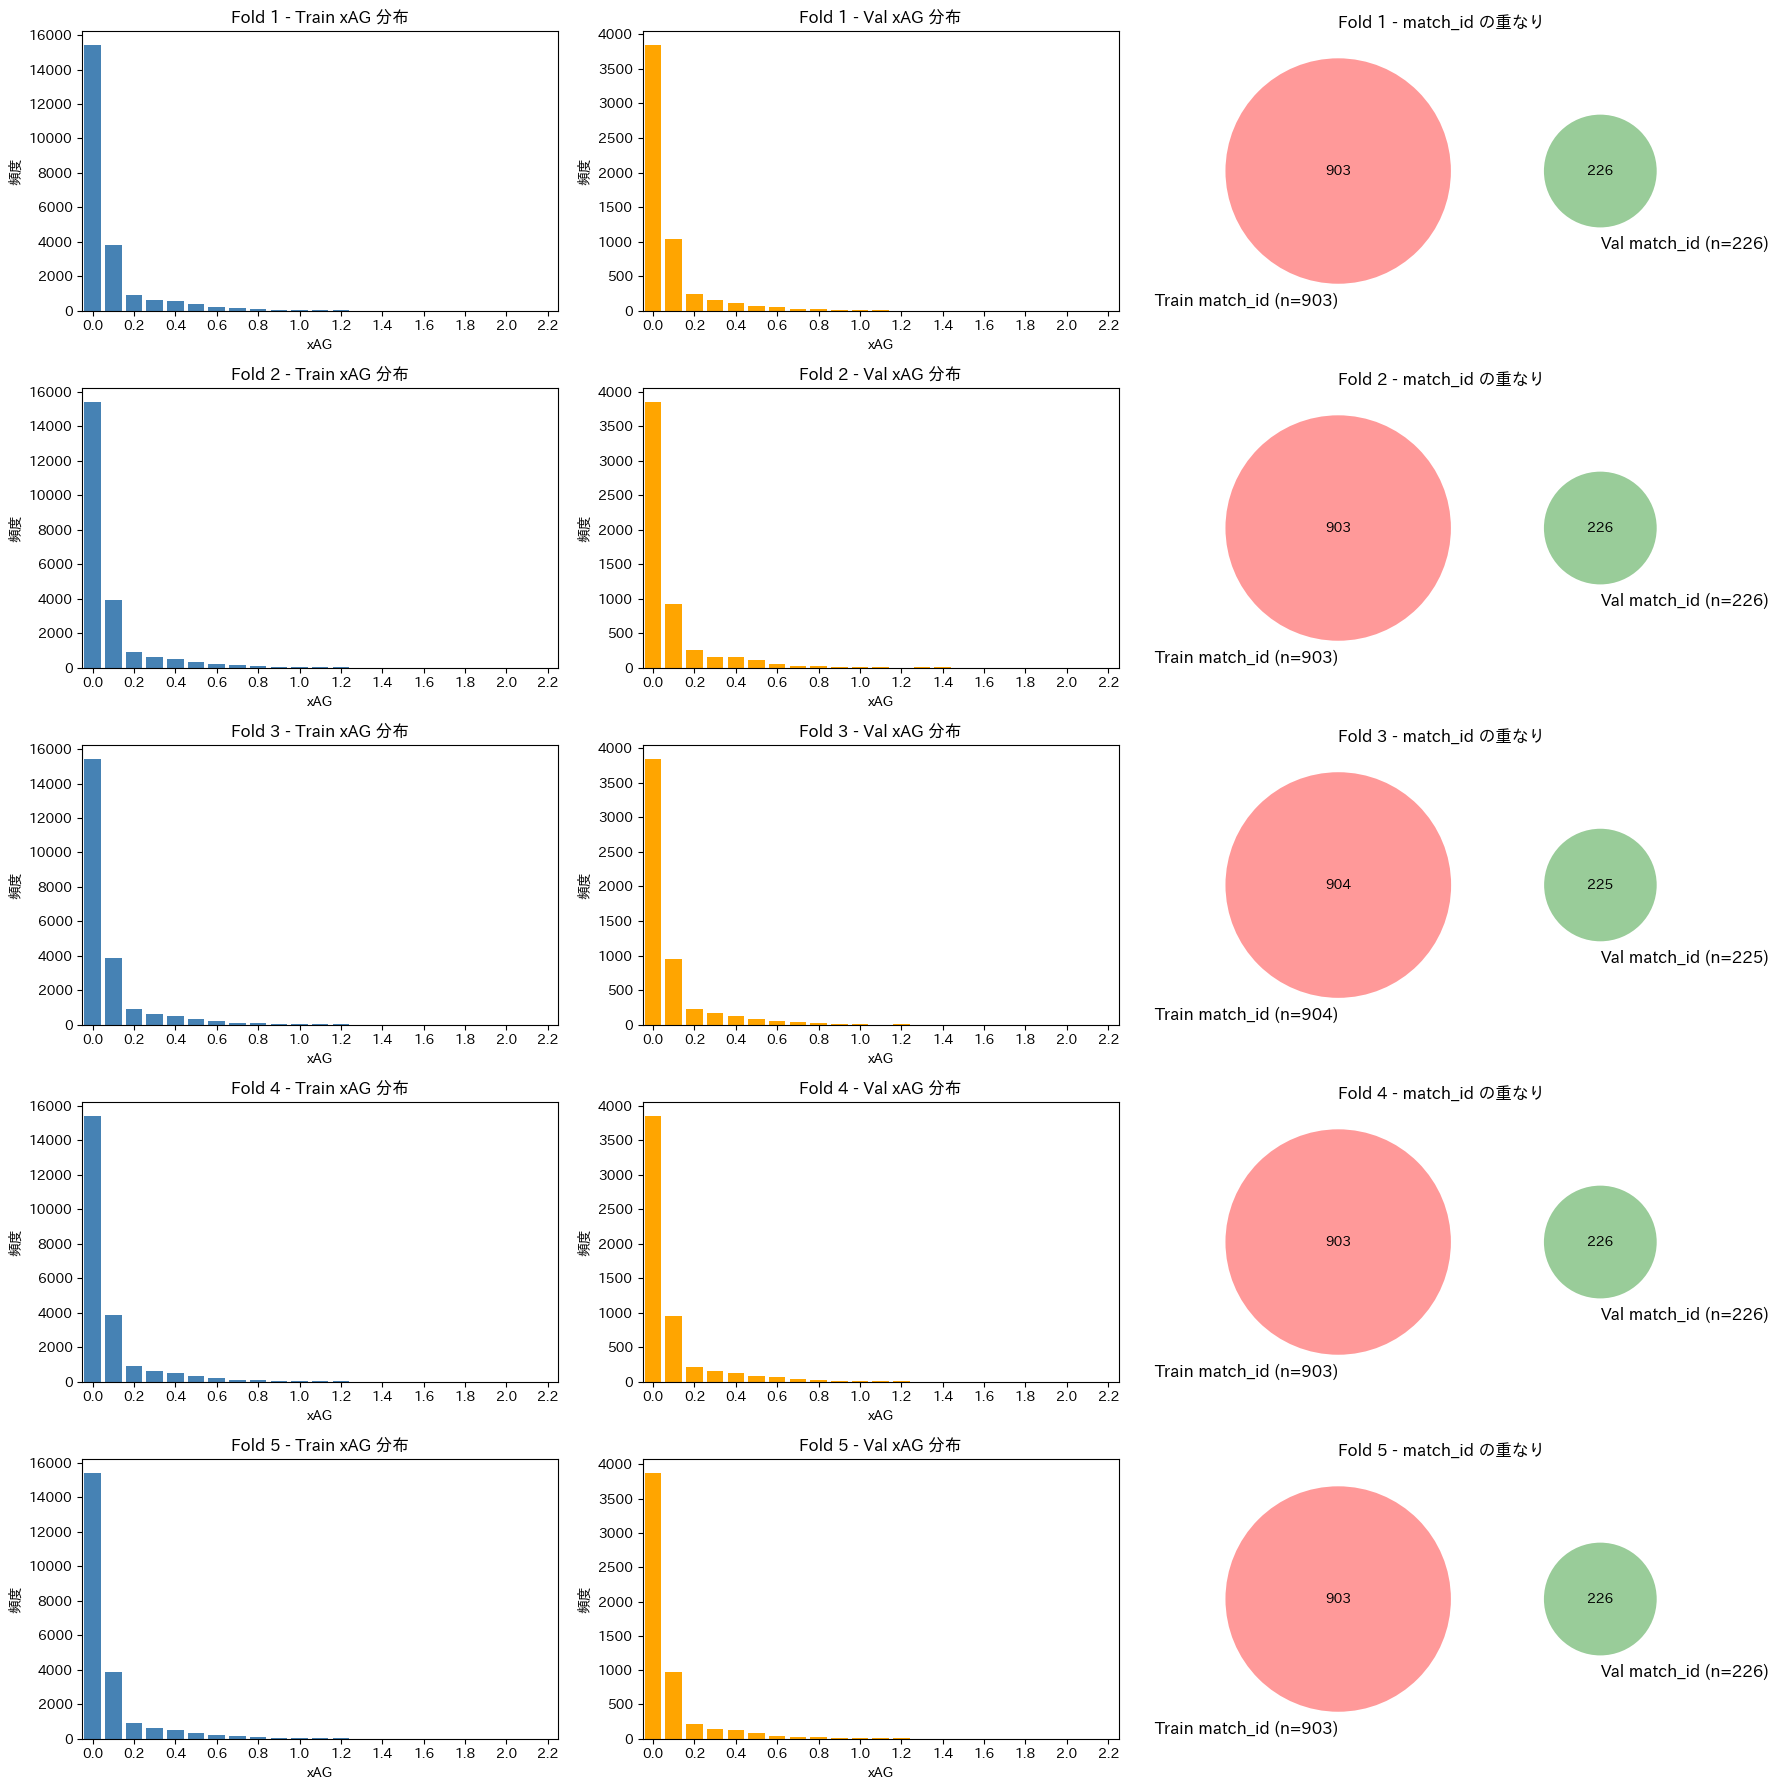

In [25]:


# 5分割のGroupKFoldを設定（match_idでグループ化）
gkf = GroupKFold(n_splits=5)
train_df["fold"] = 0  # 0で初期化

# xAG軸のスケールは共通化して見やすくする
x_min, x_max = train_df["xAG"].min(), train_df["xAG"].max()
xAG_vals = np.arange(x_min, x_max + 0.1, 0.1).round(1)

# 図: 各foldごとに 3カラム（Train分布, Val分布, match_idベン図）
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18), sharey=False, sharex=False)

for i, (trn_idx, val_idx) in enumerate(gkf.split(train_df, groups=train_df["match_id"])):
    # fold列をセット
    train_df.loc[val_idx, "fold"] = i + 1

    # train/val の xAG 分布を取得（共通スケールにリインデックス）
    trn_counts = (
        train_df.iloc[trn_idx]["xAG"].value_counts().sort_index()
        .reindex(xAG_vals, fill_value=0)
    )
    val_counts = (
        train_df.iloc[val_idx]["xAG"].value_counts().sort_index()
        .reindex(xAG_vals, fill_value=0)
    )

    # 左列: 各foldのtrainデータ分布
    ax_train = axes[i, 0]
    ax_train.bar(trn_counts.index, trn_counts.values, width=0.08, color="steelblue")
    ax_train.set_title(f"Fold {i+1} - Train xAG 分布")
    ax_train.set_xlabel("xAG")
    ax_train.set_ylabel("頻度")

    # 中列: 各foldのvalidationデータ分布
    ax_val = axes[i, 1]
    ax_val.bar(val_counts.index, val_counts.values, width=0.08, color="orange")
    ax_val.set_title(f"Fold {i+1} - Val xAG 分布")
    ax_val.set_xlabel("xAG")
    ax_val.set_ylabel("頻度")

    # 右列: match_idのベン図（Train vs Val）
    ax_venn = axes[i, 2]
    trn_match_ids = set(train_df.iloc[trn_idx]["match_id"])
    val_match_ids = set(train_df.iloc[val_idx]["match_id"])
    v = venn2(
        [trn_match_ids, val_match_ids],
        set_labels=(f"Train match_id (n={len(trn_match_ids)})",
                    f"Val match_id (n={len(val_match_ids)})"),
        ax=ax_venn
    )
    ax_venn.set_title(f"Fold {i+1} - match_id の重なり")

# x軸を共通スケールに揃える（分布図の2カラムに適用）
for i in range(5):
    for j in [0, 1]:
        ax = axes[i, j]
        ax.set_xlim(x_min - 0.05, x_max + 0.05)  # 端を少し余裕持たせる
        ax.set_xticks(xAG_vals[::2])  # ラベルの数を間引き

plt.tight_layout()
plt.show()

In [26]:


print("eΔxTのλ最適化と特徴量集約を実行中...")

import optuna
from optuna.samplers import TPESampler

edxt_feature_cols = []

if xpass_predictions_df.empty:
    print("xPassの対象アクションが存在しないため、eΔxT特徴量は追加されません。")
else:
    xpass_predictions_df = xpass_predictions_df.copy()
    xpass_predictions_df["xt_learned_delta"] = xpass_predictions_df["xt_learned_delta"].fillna(0.0)
    xpass_predictions_df["xt_learned_start"] = xpass_predictions_df["xt_learned_start"].fillna(0.0)
    xpass_predictions_df["success_component"] = xpass_predictions_df["xpass_prob"] * xpass_predictions_df["xt_learned_delta"]
    xpass_predictions_df["fail_component_raw"] = (1.0 - xpass_predictions_df["xpass_prob"]) * xpass_predictions_df["xt_learned_start"]
    xpass_predictions_df["fail_weight"] = (1.0 - xpass_predictions_df["xpass_prob"]).fillna(0.0)

    train_actions = xpass_predictions_df[xpass_predictions_df["is_train_action"]].copy()

    global_start_mean = float(train_actions["xt_learned_start"].mean()) if not train_actions.empty else 0.0
    global_start_std = float(train_actions["xt_learned_start"].std(ddof=0)) if not train_actions.empty else 0.0
    if global_start_std < 1e-6:
        global_start_std = 1.0

    global_start_median = float(train_actions["xt_learned_start"].median()) if not train_actions.empty else 0.0
    global_start_mad = float((train_actions["xt_learned_start"] - global_start_median).abs().median()) if not train_actions.empty else 0.0
    if global_start_mad < 1e-6:
        global_start_mad = 1.0

    group_mean = train_actions.groupby("xpass_action_group")["xt_learned_start"].mean()
    group_std = train_actions.groupby("xpass_action_group")["xt_learned_start"].std(ddof=0)
    group_median = train_actions.groupby("xpass_action_group")["xt_learned_start"].median()
    group_mad = train_actions.groupby("xpass_action_group")["xt_learned_start"].apply(lambda s: (s - s.median()).abs().median())

    xpass_predictions_df["fail_group_mean"] = xpass_predictions_df["xpass_action_group"].map(group_mean).fillna(global_start_mean)
    xpass_predictions_df["fail_group_std"] = xpass_predictions_df["xpass_action_group"].map(group_std).fillna(global_start_std)
    xpass_predictions_df["fail_group_std"] = xpass_predictions_df["fail_group_std"].where(xpass_predictions_df["fail_group_std"] > 1e-6, global_start_std)

    xpass_predictions_df["fail_group_median"] = xpass_predictions_df["xpass_action_group"].map(group_median).fillna(global_start_median)
    xpass_predictions_df["fail_group_mad"] = xpass_predictions_df["xpass_action_group"].map(group_mad).fillna(global_start_mad)
    xpass_predictions_df["fail_group_mad"] = xpass_predictions_df["fail_group_mad"].where(xpass_predictions_df["fail_group_mad"] > 1e-6, global_start_mad)

    pass_train = train_actions[train_actions["xpass_action_group"] == "pass"]
    if not pass_train.empty:
        pass_reference = np.sort(pass_train["xt_learned_start"].to_numpy())
    else:
        pass_reference = None

    def _quantile_center(values: np.ndarray, reference: np.ndarray) -> np.ndarray:
        if reference is None or len(reference) == 0:
            return np.zeros_like(values, dtype=float)
        ranks = np.searchsorted(reference, values, side="left")
        quantiles = (ranks + 0.5) / len(reference)
        quantiles = np.clip(quantiles, 1e-6, 1 - 1e-6)
        return quantiles - 0.5

    xpass_predictions_df["fail_component_scaled"] = 0.0

    pass_mask = xpass_predictions_df["xpass_action_group"] == "pass"
    if pass_mask.any():
        if pass_reference is not None and len(pass_reference) > 10:
            centered = _quantile_center(xpass_predictions_df.loc[pass_mask, "xt_learned_start"].to_numpy(), pass_reference)
        else:
            centered = (
                (xpass_predictions_df.loc[pass_mask, "xt_learned_start"] - xpass_predictions_df.loc[pass_mask, "fail_group_median"]) / xpass_predictions_df.loc[pass_mask, "fail_group_mad"]
            ).to_numpy()
        xpass_predictions_df.loc[pass_mask, "fail_component_scaled"] = xpass_predictions_df.loc[pass_mask, "fail_weight"].to_numpy() * centered

    non_pass_mask = ~pass_mask
    if non_pass_mask.any():
        centered = (
            xpass_predictions_df.loc[non_pass_mask, "xt_learned_start"].to_numpy() - xpass_predictions_df.loc[non_pass_mask, "fail_group_mean"].to_numpy()
        ) / xpass_predictions_df.loc[non_pass_mask, "fail_group_std"].to_numpy()
        xpass_predictions_df.loc[non_pass_mask, "fail_component_scaled"] = xpass_predictions_df.loc[non_pass_mask, "fail_weight"].to_numpy() * centered

    train_actions = xpass_predictions_df[xpass_predictions_df["is_train_action"]].copy()
    train_meta = train_df[["match_id", "player_id", "fold", "xAG"]].copy()
    fold_labels = sorted(train_df["fold"].unique())

    def _weighted_rmse_local(y_true, y_pred):
        weights = make_sample_weight(y_true)
        return float(np.sqrt(np.mean(weights * (y_true - y_pred) ** 2) + 1e-9))

    aggregated_components = (
        train_actions.groupby(["match_id", "player_id", "xpass_action_group"])
        .agg(
            success_sum=("success_component", "sum"),
            fail_sum_scaled=("fail_component_scaled", "sum"),
            fail_sum_raw=("fail_component_raw", "sum"),
            fail_weight_sum=("fail_weight", "sum"),
            action_count=("success_component", "count"),
        )
        .reset_index()
    )

    lambda_per_type = {}
    lambda_meta = []
    lambda_bounds = {
        "pass": (-0.3, 0.6),
        "cross": (-0.6, 2.0),
        "dribble": (-0.6, 2.0),
        "carry": (-0.6, 2.0),
        "corner": (-1.5, 3.0),
        "free_kick": (-1.5, 3.0),
    }

    for action_group in sorted(xpass_predictions_df["xpass_action_group"].dropna().unique()):
        type_df = aggregated_components[aggregated_components["xpass_action_group"] == action_group].copy()
        type_df = type_df.merge(train_meta, on=["match_id", "player_id"], how="left")
        type_df = type_df.dropna(subset=["xAG", "fold"])

        if type_df.empty:
            lambda_per_type[action_group] = 0.0
            continue

        lam_low, lam_high = lambda_bounds.get(action_group, (-1.0, 2.0))

        def objective(trial):
            lam = trial.suggest_float("lambda", lam_low, lam_high)
            preds = type_df["success_sum"] - lam * type_df["fail_sum_scaled"]
            scores = []
            for fold in fold_labels:
                fold_mask = type_df["fold"] == fold
                if not fold_mask.any():
                    continue
                scores.append(
                    _weighted_rmse_local(
                        type_df.loc[fold_mask, "xAG"].to_numpy(),
                        preds.loc[fold_mask].to_numpy(),
                    )
                )
            return float(np.mean(scores)) if scores else 1.0

        study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=SEED))
        study.optimize(objective, n_trials=35, show_progress_bar=False)
        best_lambda = float(study.best_params["lambda"])
        lambda_per_type[action_group] = best_lambda
        lambda_meta.append(
            {
                "action_type": action_group,
                "lambda": best_lambda,
                "lambda_min": lam_low,
                "lambda_max": lam_high,
                "train_rows": int(type_df.shape[0]),
                "actions_per_player_mean": float(type_df["action_count"].mean()),
                "fail_scaled_mean": float(type_df["fail_sum_scaled"].mean()),
            }
        )

    lambda_meta_df = pd.DataFrame(lambda_meta)
    if not lambda_meta_df.empty:
        display(lambda_meta_df.sort_values("lambda"))
        print("λ分布統計:")
        display(lambda_meta_df["lambda"].describe())

    for action_group, lam_value in lambda_per_type.items():
        type_actions = xpass_predictions_df[xpass_predictions_df["xpass_action_group"] == action_group].copy()
        if type_actions.empty:
            continue

        type_actions["edxt_value_scaled"] = type_actions["success_component"] - lam_value * type_actions["fail_component_scaled"]
        type_actions["edxt_positive_scaled"] = np.clip(type_actions["edxt_value_scaled"], 0.0, None)
        type_actions["edxt_value"] = type_actions["success_component"] - lam_value * type_actions["fail_component_raw"]
        type_actions["edxt_positive"] = np.clip(type_actions["edxt_value"], 0.0, None)

        agg_train = (
            type_actions[type_actions["is_train_action"]]
            .groupby(["match_id", "player_id"])
            .agg(
                edxt_sum=("edxt_value", "sum"),
                edxt_mean=("edxt_value", "mean"),
                edxt_max=("edxt_value", "max"),
                edxt_positive_sum=("edxt_positive", "sum"),
                edxt_positive_mean=("edxt_positive", "mean"),
                edxt_scaled_sum=("edxt_value_scaled", "sum"),
                edxt_scaled_mean=("edxt_value_scaled", "mean"),
                edxt_scaled_max=("edxt_value_scaled", "max"),
                edxt_scaled_positive_sum=("edxt_positive_scaled", "sum"),
                edxt_scaled_positive_mean=("edxt_positive_scaled", "mean"),
                edxt_count=("edxt_value", "count"),
                success_sum=("success_component", "sum"),
                fail_sum_raw=("fail_component_raw", "sum"),
                fail_sum_scaled=("fail_component_scaled", "sum"),
                fail_weight_sum=("fail_weight", "sum"),
            )
            .reset_index()
        )

        agg_test = (
            type_actions[~type_actions["is_train_action"]]
            .groupby(["match_id", "player_id"])
            .agg(
                edxt_sum=("edxt_value", "sum"),
                edxt_mean=("edxt_value", "mean"),
                edxt_max=("edxt_value", "max"),
                edxt_positive_sum=("edxt_positive", "sum"),
                edxt_positive_mean=("edxt_positive", "mean"),
                edxt_scaled_sum=("edxt_value_scaled", "sum"),
                edxt_scaled_mean=("edxt_value_scaled", "mean"),
                edxt_scaled_max=("edxt_value_scaled", "max"),
                edxt_scaled_positive_sum=("edxt_positive_scaled", "sum"),
                edxt_scaled_positive_mean=("edxt_positive_scaled", "mean"),
                edxt_count=("edxt_value", "count"),
                success_sum=("success_component", "sum"),
                fail_sum_raw=("fail_component_raw", "sum"),
                fail_sum_scaled=("fail_component_scaled", "sum"),
                fail_weight_sum=("fail_weight", "sum"),
            )
            .reset_index()
        )

        col_map = {
            "edxt_sum": f"{action_group}_edxt_sum",
            "edxt_mean": f"{action_group}_edxt_mean",
            "edxt_max": f"{action_group}_edxt_max",
            "edxt_positive_sum": f"{action_group}_edxt_positive_sum",
            "edxt_positive_mean": f"{action_group}_edxt_positive_mean",
            "edxt_scaled_sum": f"{action_group}_edxt_scaled_sum",
            "edxt_scaled_mean": f"{action_group}_edxt_scaled_mean",
            "edxt_scaled_max": f"{action_group}_edxt_scaled_max",
            "edxt_scaled_positive_sum": f"{action_group}_edxt_scaled_positive_sum",
            "edxt_scaled_positive_mean": f"{action_group}_edxt_scaled_positive_mean",
            "edxt_count": f"{action_group}_edxt_count",
            "success_sum": f"{action_group}_edxt_success_sum",
            "fail_sum_raw": f"{action_group}_edxt_fail_sum",
            "fail_sum_scaled": f"{action_group}_edxt_fail_scaled_sum",
            "fail_weight_sum": f"{action_group}_fail_weight_sum",
        }

        train_df = train_df.merge(agg_train.rename(columns=col_map), on=["match_id", "player_id"], how="left")
        test_df = test_df.merge(agg_test.rename(columns=col_map), on=["match_id", "player_id"], how="left")

        for new_col in col_map.values():
            if new_col not in train_df.columns:
                train_df[new_col] = 0.0
            if new_col not in test_df.columns:
                test_df[new_col] = 0.0
            train_df[new_col] = train_df[new_col].fillna(0.0)
            test_df[new_col] = test_df[new_col].fillna(0.0)

        edxt_feature_cols.extend(col_map.values())

    openplay_groups = {"pass", "cross", "dribble", "carry"}
    setpiece_groups = {"corner", "free_kick"}

    def _sum_columns(df, cols, new_col):
        found = [col for col in cols if col in df.columns]
        if found:
            df[new_col] = df[found].sum(axis=1)
        else:
            df[new_col] = 0.0

    setpiece_scaled_cols = [f"{g}_edxt_scaled_positive_sum" for g in setpiece_groups]
    openplay_scaled_cols = [f"{g}_edxt_scaled_positive_sum" for g in openplay_groups]
    setpiece_raw_cols = [f"{g}_edxt_positive_sum" for g in setpiece_groups]
    openplay_raw_cols = [f"{g}_edxt_positive_sum" for g in openplay_groups]

    for df in (train_df, test_df):
        _sum_columns(df, setpiece_scaled_cols, "setpiece_edxt_scaled_positive_sum")
        _sum_columns(df, openplay_scaled_cols, "openplay_edxt_scaled_positive_sum")
        _sum_columns(df, setpiece_raw_cols, "setpiece_edxt_positive_sum")
        _sum_columns(df, openplay_raw_cols, "openplay_edxt_positive_sum")

        scaled_denom = df["setpiece_edxt_scaled_positive_sum"] + df["openplay_edxt_scaled_positive_sum"]
        raw_denom = df["setpiece_edxt_positive_sum"] + df["openplay_edxt_positive_sum"]

        df["setpiece_edxt_scaled_ratio"] = np.where(scaled_denom > 0, df["setpiece_edxt_scaled_positive_sum"] / scaled_denom, 0.0)
        df["setpiece_edxt_raw_ratio"] = np.where(raw_denom > 0, df["setpiece_edxt_positive_sum"] / raw_denom, 0.0)

    edxt_feature_cols.extend([
        "setpiece_edxt_scaled_positive_sum",
        "openplay_edxt_scaled_positive_sum",
        "setpiece_edxt_positive_sum",
        "openplay_edxt_positive_sum",
        "setpiece_edxt_scaled_ratio",
        "setpiece_edxt_raw_ratio",
    ])

    edxt_feature_cols = sorted(dict.fromkeys(edxt_feature_cols))



eΔxTのλ最適化と特徴量集約を実行中...


[I 2025-10-04 01:30:41,968] A new study created in memory with name: no-name-13676469-c562-405a-a983-f4b397231cc7
[I 2025-10-04 01:30:41,972] Trial 0 finished with value: 0.6709847474875454 and parameters: {'lambda': 0.18543053481313132}. Best is trial 0 with value: 0.6709847474875454.
[I 2025-10-04 01:30:41,973] Trial 1 finished with value: 4.143549010302612 and parameters: {'lambda': 2.7782143788446225}. Best is trial 0 with value: 0.6709847474875454.
[I 2025-10-04 01:30:41,974] Trial 2 finished with value: 2.7959656037683045 and parameters: {'lambda': 1.7939727381513229}. Best is trial 0 with value: 0.6709847474875454.
[I 2025-10-04 01:30:41,975] Trial 3 finished with value: 1.9873786936175812 and parameters: {'lambda': 1.1939631788866647}. Best is trial 0 with value: 0.6709847474875454.
[I 2025-10-04 01:30:41,976] Trial 4 finished with value: 1.4320509023657746 and parameters: {'lambda': -0.7979161180090357}. Best is trial 0 with value: 0.6709847474875454.
[I 2025-10-04 01:30:41,97

,action_type,lambda,lambda_min,lambda_max,train_rows,actions_per_player_mean,fail_scaled_mean
2,dribble,-0.063975,-0.6,2.0,24546,4.929479,0.012699
3,free_kick,-0.052048,-1.5,3.0,2901,1.653568,0.029728
4,pass,-0.050234,-0.3,0.6,27405,31.712461,-0.050288
1,cross,-0.023235,-0.6,2.0,13917,2.504635,0.054383
0,corner,-0.018068,-1.5,3.0,3569,2.384982,0.033656


λ分布統計:


count    5.000000
mean    -0.041512
std      0.019845
min     -0.063975
25%     -0.052048
50%     -0.050234
75%     -0.023235
max     -0.018068
Name: lambda, dtype: float64

In [27]:


print("チーム文脈特徴量を追加しています...")

team_context_feature_cols = []
team_base_candidates = [
    col
    for col in train_df.columns
    if col.startswith("xt_learned_") or col.startswith("possession_xt_") or col.endswith("_edxt_sum")
]
team_base_columns = [col for col in team_base_candidates if np.issubdtype(train_df[col].dtype, np.number)]

if team_base_columns:
    for df in (train_df, test_df):
        for col in team_base_columns:
            team_sum = df.groupby(["match_id", "Squad"])[col].transform("sum")
            sum_col = f"{col}_team_sum"
            share_col = f"{col}_team_share"
            lopo_col = f"{col}_team_lopo"
            df[sum_col] = team_sum
            df[share_col] = np.where(team_sum != 0, df[col] / team_sum, 0.0)
            df[lopo_col] = team_sum - df[col]
            df[sum_col] = df[sum_col].fillna(0.0)
            df[share_col] = df[share_col].fillna(0.0)
            df[lopo_col] = df[lopo_col].fillna(0.0)
            if df is train_df:
                team_context_feature_cols.extend([sum_col, share_col, lopo_col])

    team_context_feature_cols = sorted(dict.fromkeys(team_context_feature_cols))
else:
    team_context_feature_cols = []

チーム文脈特徴量を追加しています...


In [28]:


print("リーグ別ゲーティング特徴を作成しています...")

comp_interaction_feature_cols = []
comp_cross_base_features = [
    col
    for col in [
        "xt_learned_delta_sum",
        "xt_learned_positive_delta_sum",
        "possession_xt_positive_sum",
        "possession_xt_delta_sum",
        "possession_speed_ground_mean",
    ]
    if col in train_df.columns
]

if comp_cross_base_features:
    comp_dummy_train = pd.get_dummies(train_df["Comp"].astype(str), prefix="comp_gate", dtype=float)
    comp_dummy_test = pd.get_dummies(test_df["Comp"].astype(str), prefix="comp_gate", dtype=float)
    comp_dummy_train, comp_dummy_test = comp_dummy_train.align(comp_dummy_test, join="outer", axis=1, fill_value=0.0)
    comp_dummy_test = comp_dummy_test[comp_dummy_train.columns]

    train_base = train_df[comp_cross_base_features].fillna(0.0)
    test_base = test_df[comp_cross_base_features].fillna(0.0)

    for base_col in comp_cross_base_features:
        train_values = train_base[base_col].to_numpy()
        test_values = test_base[base_col].to_numpy()
        for comp_col in comp_dummy_train.columns:
            feat_name = f"{base_col}__{comp_col}"
            train_df[feat_name] = train_values * comp_dummy_train[comp_col].to_numpy()
            test_df[feat_name] = test_values * comp_dummy_test[comp_col].to_numpy()
            comp_interaction_feature_cols.append(feat_name)

    comp_interaction_feature_cols = sorted(dict.fromkeys(comp_interaction_feature_cols))
else:
    comp_interaction_feature_cols = []


# ## 特徴量の統合
# 
# 作成した全ての特徴量を統合し、train/testデータにマージします。

リーグ別ゲーティング特徴を作成しています...


In [29]:


# 応用特徴量をtrain/testへマージ
train_df = (
    train_df
    .merge(success_rates, on=['match_id', 'player_id'], how='left')
    .merge(zone_actions, on=['match_id', 'player_id'], how='left')
    .merge(per_minute_features, on=['match_id', 'player_id'], how='left')
    .merge(offense_defense_balance, on=['match_id', 'player_id'], how='left')
    .merge(pass_leads_to_shot, on=['match_id', 'player_id'], how='left')
    .merge(progressive_features, on=['match_id', 'player_id'], how='left')
)

train_df['pass_leads_to_shot'] = train_df['pass_leads_to_shot'].fillna(0)

progressive_cols = [col for col in progressive_features.columns if col not in ['match_id', 'player_id']]
for col in progressive_cols:
    train_df[col] = train_df[col].fillna(0.0)


test_df = (
    test_df
    .merge(success_rates, on=['match_id', 'player_id'], how='left')
    .merge(zone_actions, on=['match_id', 'player_id'], how='left')
    .merge(per_minute_features, on=['match_id', 'player_id'], how='left')
    .merge(offense_defense_balance, on=['match_id', 'player_id'], how='left')
    .merge(pass_leads_to_shot, on=['match_id', 'player_id'], how='left')
    .merge(progressive_features, on=['match_id', 'player_id'], how='left')
)

test_df['pass_leads_to_shot'] = test_df['pass_leads_to_shot'].fillna(0)
for col in progressive_cols:
    test_df[col] = test_df[col].fillna(0.0)

print(f"マージ後のtrainデータshape: {train_df.shape}")
print(f"マージ後のtestデータshape: {test_df.shape}")


# ## クロスバリデーション分割
# 
# 初回のbaselineでは、全データをランダムに分割するKFoldを用いましたが、今回はデータ特性に合わせた別の分割方法を行います。
# 
# EDAで確認したように、今回はtrainデータとtestデータについては、match_idの重なりはありません。
# すなわち、testデータを予測するときには、これまで見たことのない試合のデータに対して予測をする必要があります。
# この状況をtrainデータ内部でのCross Validationでもなるべく再現することによって、実際のタスクに近い状況で正しい評価が可能になります。
# 
# ここでは、GroupKFoldを用いて、trainデータをmatch_idが被らないように5分割します。こうすることで、各foldでのtrainデータとvalidデータのmatch_idが重ならなくなります。
# 

# ## モデル学習用データ準備

マージ後のtrainデータshape: (27870, 281)
マージ後のtestデータshape: (12798, 279)


In [30]:


# ターゲットエンコーディング特徴量の作成
print("ターゲットエンコーディング特徴量を作成中...")

# Squad×Opponentの交互作用特徴を作成
train_df["Squad_x_Opponent"] = train_df["Squad"].astype(str) + "_vs_" + train_df["Opponent"].astype(str)
test_df["Squad_x_Opponent"] = test_df["Squad"].astype(str) + "_vs_" + test_df["Opponent"].astype(str)

target_encoding_cols = ["player_id", "Squad", "Opponent", "Squad_x_Opponent"]
global_mean = train_df["xAG"].mean()
smoothing = 10.0
fold_labels = sorted(train_df["fold"].unique())

for col in target_encoding_cols:
    enc_col = f"{col}_target_enc"
    train_df[enc_col] = np.nan

    for fold in fold_labels:
        trn = train_df[train_df["fold"] != fold]
        val_mask = train_df["fold"] == fold

        stats = trn.groupby(col)["xAG"].agg(["sum", "count"])
        stats["encoding"] = (stats["sum"] + global_mean * smoothing) / (stats["count"] + smoothing)

        train_df.loc[val_mask, enc_col] = train_df.loc[val_mask, col].map(stats["encoding"]).fillna(global_mean)

    overall_stats = train_df.groupby(col)["xAG"].agg(["sum", "count"])
    overall_stats["encoding"] = (overall_stats["sum"] + global_mean * smoothing) / (overall_stats["count"] + smoothing)

    test_df[enc_col] = test_df[col].map(overall_stats["encoding"]).fillna(global_mean)

    missing_train = train_df[enc_col].isna().sum()
    missing_test = test_df[enc_col].isna().sum()

    if missing_train > 0:
        train_df.loc[train_df[enc_col].isna(), enc_col] = global_mean
    if missing_test > 0:
        test_df.loc[test_df[enc_col].isna(), enc_col] = global_mean

    print(f"  {col}: train missing {int(missing_train)}, test missing {int(missing_test)}")

print("リーグ/チームバイアス調整特徴を計算中...")

train_df["Comp_target_enc"] = np.nan
comp_smoothing = 5.0

for fold in fold_labels:
    trn = train_df[train_df["fold"] != fold]
    val_mask = train_df["fold"] == fold

    comp_stats = trn.groupby("Comp")["xAG"].agg(["sum", "count"])
    comp_stats["encoding"] = (comp_stats["sum"] + global_mean * comp_smoothing) / (comp_stats["count"] + comp_smoothing)

    train_df.loc[val_mask, "Comp_target_enc"] = train_df.loc[val_mask, "Comp"].map(comp_stats["encoding"]).fillna(global_mean)

comp_overall_stats = train_df.groupby("Comp")["xAG"].agg(["sum", "count"])
comp_overall_stats["encoding"] = (comp_overall_stats["sum"] + global_mean * comp_smoothing) / (comp_overall_stats["count"] + comp_smoothing)

test_df["Comp_target_enc"] = test_df["Comp"].map(comp_overall_stats["encoding"]).fillna(global_mean)

train_df["Comp_target_enc"] = train_df["Comp_target_enc"].fillna(global_mean)

test_df["Comp_target_enc"] = test_df["Comp_target_enc"].fillna(global_mean)

train_df["Squad_comp_residual"] = train_df["Squad_target_enc"] - train_df["Comp_target_enc"]
test_df["Squad_comp_residual"] = test_df["Squad_target_enc"] - test_df["Comp_target_enc"]

train_df["Squad_global_residual"] = train_df["Squad_target_enc"] - global_mean
test_df["Squad_global_residual"] = test_df["Squad_target_enc"] - global_mean

# diff between Squad and Opponent TE for matchup effect
train_df["Squad_vs_opponent_gap"] = train_df["Squad_target_enc"] - train_df["Opponent_target_enc"]
test_df["Squad_vs_opponent_gap"] = test_df["Squad_target_enc"] - test_df["Opponent_target_enc"]

print("  Squad_comp_residual などの新特徴を追加しました。")



ターゲットエンコーディング特徴量を作成中...
  player_id: train missing 0, test missing 0
  Squad: train missing 0, test missing 0
  Opponent: train missing 0, test missing 0
  Squad_x_Opponent: train missing 0, test missing 0
リーグ/チームバイアス調整特徴を計算中...
  Squad_comp_residual などの新特徴を追加しました。


In [31]:


# 各特徴量グループの定義
base_features = ["age", "action_count", "avg_x", "avg_y", "minutes_played", "goal_count"]
categorical_features = ["Comp", "Squad", "Venue"]
action_type_features = [col for col in train_df.columns if (col.startswith('type_')) and (col.endswith('_count'))]
success_rate_features = [
    col for col in train_df.columns
    if col.endswith('_success_rate') and not col.startswith('progressive_')
]
zone_features = [col for col in train_df.columns if col.startswith('zone_')]
per_minute_features = [col for col in train_df.columns if col.endswith('_per_minute')]
ad_balance_features = ['type_offensive_actions', 'type_defensive_actions', 'type_offensive_action_ratio']
sequencial_features = ['pass_leads_to_shot']
progressive_feature_cols = [
    col for col in train_df.columns
    if col.startswith('progressive_')
    or col in ['deep_completion_count', 'final_third_entry_count', 'penalty_area_entry_count']
]
xt_cols = [col for col in train_df.columns if col.startswith('xt_')]
target_encoding_features = [f"{col}_target_enc" for col in ["player_id", "Squad", "Opponent", "Squad_x_Opponent"]]
extra_bias_features = ["Comp_target_enc", "Squad_comp_residual", "Squad_global_residual", "Squad_vs_opponent_gap"]
possession_features = [col for col in train_df.columns if col.startswith('possession_')]
pass_network_features = [col for col in train_df.columns if col.startswith('pass_net_')]
edxt_features = sorted(globals().get('edxt_feature_cols', []))
team_context_features = sorted(globals().get('team_context_feature_cols', []))
comp_interaction_features = sorted(globals().get('comp_interaction_feature_cols', []))

all_features = (
    base_features
    + categorical_features
    + action_type_features
    + success_rate_features
    + zone_features
    + per_minute_features
    + ad_balance_features
    + sequencial_features
    + progressive_feature_cols
    + xt_cols
    + target_encoding_features
    + extra_bias_features
    + possession_features
    + pass_network_features
    + edxt_features
    + team_context_features
    + comp_interaction_features
)

all_features = list(dict.fromkeys(all_features))

# カテゴリカル変数については、列の型を「category」に変更しておく
for col in categorical_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")

print(f"  - 使用する特徴量数: {len(all_features)}個")
print(f"  - 基本特徴量: {len(base_features)}個")
print(f"  - カテゴリカル特徴量: {len(categorical_features)}個")
print(f"  - アクション特徴量(type_*_count): {len(action_type_features)}個")
print(f"  - 成功率系: {len(success_rate_features)}個")
print(f"  - ゾーン系: {len(zone_features)}個")
print(f"  - per_minute系: {len(per_minute_features)}個")
print(f"  - 攻守バランス系: {len(ad_balance_features)}個")
print(f"  - 時系列系: {len(sequencial_features)}個")
print(f"  - プログレッシブ系: {len(progressive_feature_cols)}個")
print(f"  - xT系: {len(xt_cols)}個")
print(f"  - ターゲットエンコーディング系: {len(target_encoding_features)}個")
print(f"  - ポゼッション進攻系: {len(possession_features)}個")
print(f"  - パスネットワーク系: {len(pass_network_features)}個")
print(f"  - eΔxT系: {len(edxt_features)}個")
print(f"  - チーム文脈系: {len(team_context_features)}個")
print(f"  - リーグ相互作用系: {len(comp_interaction_features)}個")

  - 使用する特徴量数: 277個
  - 基本特徴量: 6個
  - カテゴリカル特徴量: 3個
  - アクション特徴量(type_*_count): 19個
  - 成功率系: 7個
  - ゾーン系: 6個
  - per_minute系: 21個
  - 攻守バランス系: 3個
  - 時系列系: 1個
  - プログレッシブ系: 13個
  - xT系: 50個
  - ターゲットエンコーディング系: 4個
  - ポゼッション進攻系: 37個
  - パスネットワーク系: 8個
  - eΔxT系: 81個
  - チーム文脈系: 54個
  - リーグ相互作用系: 25個


In [32]:


# モデル学習用データの作成
X_train = train_df[all_features + ["fold"]]
y_train = train_df["xAG"]
X_test = test_df[all_features]

print(f"\nモデル学習用データ形状: X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}")


# ## Soft Mixture-of-Experts による最終モデル
# 
# 分類確率で滑らかに切り替えるSoft MoEを導入し、低xAG・高xAGの専門家回帰器とゲーティング分類器を協調させます。ゲーティング確率はアイソトニック回帰でfold外キャリブレーションし、閾値0.1近傍の密度を高めます。


モデル学習用データ形状: X_train (27870, 278), y_train (27870,), X_test (12798, 277)


In [33]:


from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import average_precision_score, roc_auc_score

MOE_THRESHOLD = WEIGHTED_TARGET_THRESHOLD
fold_labels = sorted(train_df["fold"].unique())
moe_features = list(all_features)

feature_matrix = train_df[moe_features].copy()
test_matrix = test_df[moe_features].copy()

target_series = train_df["xAG"].astype(float)
binary_target = (target_series >= MOE_THRESHOLD).astype(int)

print(f"MoEしきい値: {MOE_THRESHOLD:.3f}, 高xAG比率: {binary_target.mean():.3f}")
print(f"利用特徴量数: {len(moe_features)}")

MoEしきい値: 0.280, 高xAG比率: 0.092
利用特徴量数: 277


In [34]:


try:
    base_dir = Path(__file__).resolve().parent
except NameError:
    base_dir = Path.cwd()

log_dir = base_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)

gating_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 48,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 64,
    "min_gain_to_split": 0.0,
    "seed": SEED,
    "verbosity": -1,
}

low_expert_params = {
    "objective": "regression_l2",
    "metric": "rmse",
    "learning_rate": 0.1,  # 0.05 → 0.1 (高速学習)
    "num_leaves": 7,  # 64 → 7 (浅い木でシンプルパターン)
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 1,  # 80 → 1 (過剰正則化を解除)
    "max_depth": 3,  # 追加: 木の深さ制限
    "seed": SEED,
    "verbosity": -1,
}

high_expert_params = {
    "objective": "regression_l2",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "min_data_in_leaf": 40,
    "seed": SEED,
    "verbosity": -1,
}


def compute_iso_sample_weight(target_array, threshold):
    weights = np.ones_like(target_array, dtype=float)
    deltas = np.abs(target_array - threshold)
    weights[deltas <= 0.01] = 5.0
    weights[(deltas > 0.01) & (deltas <= 0.03)] = 3.0
    weights[(deltas > 0.03) & (deltas <= 0.05)] = 2.0
    return weights


def save_moe_run(cv_scores, oof_score, gating_metrics, log_directory, log_prefix="host_soft_moe"):
    timestamp = datetime.now().astimezone().isoformat(timespec="seconds")

    payload = {
        "run_timestamp": timestamp,
        "cv": {
            "scores": [float(score) for score in cv_scores],
            "mean": float(np.mean(cv_scores)),
            "std": float(np.std(cv_scores)),
        },
        "per_fold": {f"fold_{idx + 1}": float(score) for idx, score in enumerate(cv_scores)},
        "oof_rmse": float(oof_score),
        "gating": {
            "threshold": float(gating_metrics.get("threshold", MOE_THRESHOLD)),
            "auc": float(gating_metrics.get("auc", np.nan)),
            "average_precision": float(gating_metrics.get("average_precision", np.nan)),
        },
    }

    metrics_path = log_directory / f"{log_prefix}_metrics.json"
    metrics_path.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding="utf-8")

    log_lines = [
        f"[{timestamp}] {log_prefix}",
        f"  CV mean: {payload['cv']['mean']:.4f}",
        f"  CV std: {payload['cv']['std']:.4f}",
        f"  OOF RMSE: {payload['oof_rmse']:.4f}",
        f"  Gating AUC: {payload['gating']['auc']:.4f}",
        f"  Gating AP: {payload['gating']['average_precision']:.4f}",
    ]
    for idx, score in enumerate(cv_scores, start=1):
        log_lines.append(f"  Fold {idx}: {score:.4f}")

    log_path = log_directory / f"{log_prefix}_training.log"
    with log_path.open("a", encoding="utf-8") as fp:
        fp.write("".join(log_lines) + "")

In [35]:


print("Soft MoE学習を開始します...")

n_train = len(train_df)
n_test = len(test_df)

gating_oof_raw = np.zeros(n_train, dtype=float)
low_oof = np.zeros(n_train, dtype=float)
high_oof = np.zeros(n_train, dtype=float)

gating_test_raw_sum = np.zeros(n_test, dtype=float)
low_test_sum = np.zeros(n_test, dtype=float)
high_test_sum = np.zeros(n_test, dtype=float)

low_importance_frames = []
high_importance_frames = []
gating_importance_frames = []

for fold in fold_labels:
    print(f"=== Soft MoE Fold {fold} ===")
    train_mask = train_df["fold"] != fold
    val_mask = train_df["fold"] == fold

    train_idx = train_df.index[train_mask]
    val_idx = train_df.index[val_mask]

    X_tr = feature_matrix.loc[train_idx]
    X_val = feature_matrix.loc[val_idx]
    y_tr = target_series.loc[train_idx]
    y_val = target_series.loc[val_idx]
    binary_tr = binary_target.loc[train_idx]
    binary_val = binary_target.loc[val_idx]

    gating_weights = np.where(binary_tr == 1, WEIGHTED_POSITIVE_WEIGHT, 1.0)
    gating_train = lgb.Dataset(X_tr, label=binary_tr, weight=gating_weights)
    gating_val = lgb.Dataset(X_val, label=binary_val)

    gating_model = lgb.train(
        gating_params,
        gating_train,
        valid_sets=[gating_train, gating_val],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(150), lgb.log_evaluation(0)],
    )

    gating_val_pred = gating_model.predict(X_val, num_iteration=gating_model.best_iteration)
    gating_oof_raw[val_idx] = gating_val_pred
    gating_test_raw_sum += gating_model.predict(test_matrix, num_iteration=gating_model.best_iteration)

    gating_importance_frames.append(pd.DataFrame({
        "feature": moe_features,
        "importance": gating_model.feature_importance(importance_type="gain"),
        "fold": fold,
    }))

    low_idx = train_df.index[train_mask & (target_series < MOE_THRESHOLD)]
    if len(low_idx) < 100:
        low_idx = train_idx

    low_train = lgb.Dataset(feature_matrix.loc[low_idx], label=target_series.loc[low_idx])
    low_val = lgb.Dataset(X_val, label=y_val)

    low_model = lgb.train(
        low_expert_params,
        low_train,
        valid_sets=[low_val],
        valid_names=["val"],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(150), lgb.log_evaluation(0)],
    )

    low_val_pred = low_model.predict(X_val, num_iteration=low_model.best_iteration)
    low_oof[val_idx] = low_val_pred
    low_test_sum += low_model.predict(test_matrix, num_iteration=low_model.best_iteration)

    low_importance_frames.append(pd.DataFrame({
        "feature": moe_features,
        "importance": low_model.feature_importance(importance_type="gain"),
        "fold": fold,
    }))

    high_idx = train_df.index[train_mask & (target_series >= MOE_THRESHOLD)]
    if len(high_idx) < 100:
        high_idx = train_idx

    high_weights = make_sample_weight(target_series.loc[high_idx])
    high_train = lgb.Dataset(
        feature_matrix.loc[high_idx],
        label=target_series.loc[high_idx],
        weight=high_weights,
    )
    high_val = lgb.Dataset(X_val, label=y_val)

    high_model = lgb.train(
        high_expert_params,
        high_train,
        valid_sets=[high_val],
        valid_names=["val"],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(150), lgb.log_evaluation(0)],
    )

    high_val_pred = high_model.predict(X_val, num_iteration=high_model.best_iteration)
    high_oof[val_idx] = high_val_pred
    high_test_sum += high_model.predict(test_matrix, num_iteration=high_model.best_iteration)

    high_importance_frames.append(pd.DataFrame({
        "feature": moe_features,
        "importance": high_model.feature_importance(importance_type="gain"),
        "fold": fold,
    }))

Soft MoE学習を開始します...
=== Soft MoE Fold 1 ===
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[353]	train's binary_logloss: 0.0575985	val's binary_logloss: 0.224074
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[943]	val's rmse: 0.135818
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[119]	val's rmse: 0.393421
=== Soft MoE Fold 2 ===
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[282]	train's binary_logloss: 0.0752931	val's binary_logloss: 0.237001
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[137]	val's rmse: 0.152381
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[110]	val's rmse: 0.388979
=== Soft MoE Fold 3 ===
Training until validation scores don't improve for 150 rounds
Early stopping

In [36]:


print("キャリブレーションを実行中...")

gating_test_raw_mean = gating_test_raw_sum / len(fold_labels)
low_test_mean = low_test_sum / len(fold_labels)
high_test_mean = high_test_sum / len(fold_labels)

iso_weights = compute_iso_sample_weight(target_series.to_numpy(), MOE_THRESHOLD)
iso_model = IsotonicRegression(out_of_bounds="clip", y_min=0.0, y_max=1.0)
iso_model.fit(gating_oof_raw, binary_target.to_numpy(), sample_weight=iso_weights)

gating_oof_calibrated = iso_model.predict(gating_oof_raw)
gating_test_calibrated = iso_model.predict(gating_test_raw_mean)

moe_oof_preds = (1.0 - gating_oof_calibrated) * low_oof + gating_oof_calibrated * high_oof
moe_test_preds = (1.0 - gating_test_calibrated) * low_test_mean + gating_test_calibrated * high_test_mean

moe_fold_scores = []
for fold in fold_labels:
    val_idx = train_df.index[train_df["fold"] == fold]
    score = weighted_rmse(target_series.loc[val_idx], moe_oof_preds[val_idx])
    moe_fold_scores.append(score)
    print(f"Fold {fold}: Weighted RMSE = {score:.4f}")

moe_oof_rmse = weighted_rmse(target_series, moe_oof_preds)
print(f"OOF Weighted RMSE (Soft MoE): {moe_oof_rmse:.4f}")

gating_auc = roc_auc_score(binary_target, gating_oof_raw)
gating_ap = average_precision_score(binary_target, gating_oof_raw)
print(f"Gating AUC: {gating_auc:.4f}, Average Precision: {gating_ap:.4f}")

gating_metrics = {
    "threshold": MOE_THRESHOLD,
    "auc": gating_auc,
    "average_precision": gating_ap,
}

save_moe_run(moe_fold_scores, moe_oof_rmse, gating_metrics, log_dir)

train_df["moe_oof_pred"] = moe_oof_preds
train_df["moe_gating_prob"] = gating_oof_calibrated

submission_df["xAG"] = moe_test_preds
test_df["predicted_xAG"] = moe_test_preds

display(train_df[["xAG", "moe_oof_pred", "moe_gating_prob"]].head())

キャリブレーションを実行中...
Fold 1: Weighted RMSE = 0.2179
Fold 2: Weighted RMSE = 0.2413
Fold 3: Weighted RMSE = 0.2283
Fold 4: Weighted RMSE = 0.2300
Fold 5: Weighted RMSE = 0.2287
OOF Weighted RMSE (Soft MoE): 0.2294
Gating AUC: 0.8756, Average Precision: 0.4639


,xAG,moe_oof_pred,moe_gating_prob
0,0.1,0.170105,0.247002
1,0.0,0.056578,0.066437
2,0.0,0.023240,0.070074
3,0.0,0.020961,0.021429
4,0.1,0.131761,0.124694


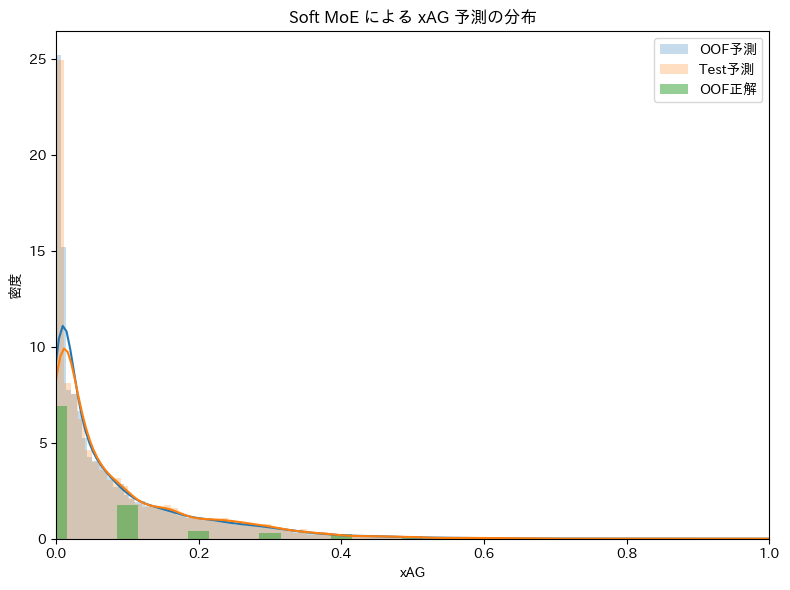

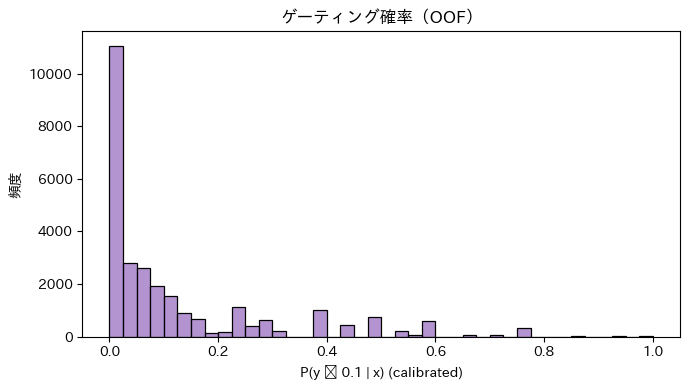

In [37]:


plt.figure(figsize=(8, 6))
sns.histplot(moe_oof_preds, stat='density', kde=True, alpha=0.25, label='OOF予測', linewidth=0)
sns.histplot(moe_test_preds, stat='density', kde=True, alpha=0.25, label='Test予測', linewidth=0)

vc = target_series.value_counts().sort_index()
heights = vc / vc.sum() / 0.1
plt.bar(vc.index, heights, width=0.03, alpha=0.5, label='OOF正解', align='center')

plt.xlabel('xAG')
plt.ylabel('密度')
plt.xlim(0, 1)
plt.title('Soft MoE による xAG 予測の分布')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(gating_oof_calibrated, bins=40, alpha=0.7, color='tab:purple')
plt.xlabel('P(y ≥ 0.1 | x) (calibrated)')
plt.ylabel('頻度')
plt.title('ゲーティング確率（OOF）')
plt.tight_layout()
plt.show()

In [38]:


def summarize_importance(frames, label):
    if not frames:
        print(f"{label}: データがありません")
        return None
    df = pd.concat(frames, axis=0)
    summary = df.groupby('feature')['importance'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    print(f"{label} 上位特徴量:")
    display(summary.head(10))
    return summary

low_importance_summary = summarize_importance(low_importance_frames, 'Low expert')
high_importance_summary = summarize_importance(high_importance_frames, 'High expert')
gating_importance_summary = summarize_importance(gating_importance_frames, 'Gating model')

Low expert 上位特徴量:


,mean,std
feature,,
pass_leads_to_shot,44.181262,1.382330
penalty_area_entry_count,19.495948,3.956151
Squad,17.826419,7.378898
xt_learned_end_success_mean,6.140298,0.862353
xt_learned_positive_delta_mean,5.540435,0.756322
xt_learned_positive_delta_sum,5.254126,0.873599
setpiece_edxt_positive_sum,3.444303,1.204026
setpiece_edxt_scaled_positive_sum,3.182843,1.621888
deep_completion_count,3.045999,3.299657


High expert 上位特徴量:


,mean,std
feature,,
Squad,369.480203,53.225423
openplay_edxt_positive_sum,177.066608,57.345090
pass_edxt_max,119.736583,16.402047
openplay_edxt_scaled_positive_sum,79.336066,30.431859
pass_edxt_positive_sum,78.522216,35.221016
possession_xt_delta_sum,75.030047,36.849425
pass_leads_to_shot,74.751014,20.797818
cross_edxt_max,64.309989,16.297922
pass_edxt_scaled_positive_sum,56.133315,25.440242


Gating model 上位特徴量:


,mean,std
feature,,
Squad,46887.039542,1299.726840
xt_learned_positive_delta_mean,42760.321005,4982.988500
pass_leads_to_shot,18233.105994,792.577043
openplay_edxt_scaled_positive_sum,14813.177470,7820.725459
xt_learned_positive_delta_sum,9492.917834,4874.272027
xt_learned_end_success_mean,8481.640055,1705.837231
pass_edxt_max,5655.753969,509.269795
openplay_edxt_positive_sum,4472.816449,1943.631451
pass_edxt_scaled_max,4303.999346,730.258417


In [39]:


submission_path = log_dir / 'submission_soft_moe.csv'
submission_df.to_csv(submission_path, index=False)

print("=== Soft MoE サマリー ===")
print(f"OOF Weighted RMSE: {moe_oof_rmse:.4f}")
print(f"Gating AUC: {gating_auc:.4f}")
print(f"Gating Average Precision: {gating_ap:.4f}")
print(f"提出ファイル: {submission_path}")
print(submission_df['xAG'].describe())

=== Soft MoE サマリー ===
OOF Weighted RMSE: 0.2294
Gating AUC: 0.8756
Gating Average Precision: 0.4639
提出ファイル: /workspace/experiments/exp0023/logs/submission_soft_moe.csv
count    12798.000000
mean         0.087290
std          0.107476
min         -0.009371
25%          0.009274
50%          0.042940
75%          0.126979
max          1.013897
Name: xAG, dtype: float64
